<a href="https://colab.research.google.com/github/sebascm/TFM_Source_Code/blob/main/TFM_v4_EDA_Model_Train_ROTURAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error, explained_variance_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Carga de datos

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
date_cols = ['idSecuencia']
ruta = "/content/drive/Othercomputers/Mi portátil/UOC/4o Semestre/TFM/Datos/data_ventas_stock_calendario_joined.csv"
data_ventas_stock_calendario = pd.read_csv(ruta, parse_dates=date_cols)

In [ ]:
data_ventas_stock_calendario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706640 entries, 0 to 706639
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   producto         706640 non-null  int64         
 1   idSecuencia      706640 non-null  datetime64[ns]
 2   udsVenta         706640 non-null  int64         
 3   udsStock         706640 non-null  int64         
 4   bolOpen          706640 non-null  int64         
 5   bolHoliday       706640 non-null  int64         
 6   estaEnPromocion  706640 non-null  int64         
 7   año              706640 non-null  int64         
 8   mes              706640 non-null  int64         
 9   dia              706640 non-null  int64         
 10  dia_semana       706640 non-null  int64         
 11  semana_mes       706640 non-null  int64         
 12  semana_año       706640 non-null  int64         
dtypes: datetime64[ns](1), int64(12)
memory usage: 70.1 MB


# **Outliers**


In [ ]:
data_ventas_stock_calendario_out = data_ventas_stock_calendario

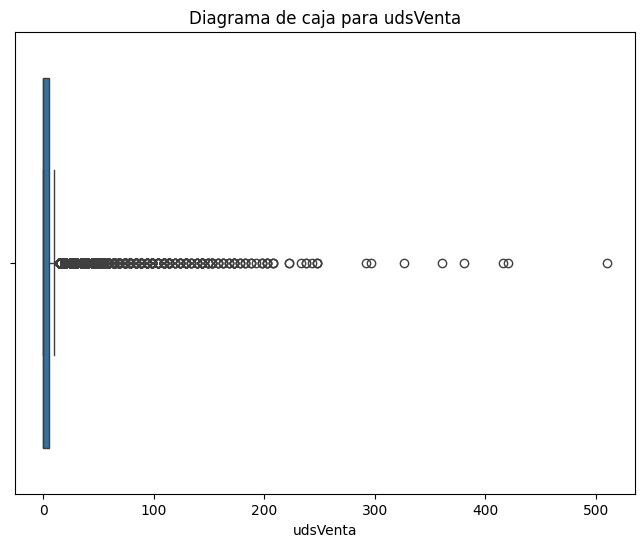

In [ ]:
# Crear un diagrama de caja para identificar outliers en udsVenta
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_ventas_stock_calendario_out['udsVenta'])
plt.title('Diagrama de caja para udsVenta')
plt.xlabel('udsVenta')
plt.show()

In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['udsVenta'] == 510]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año
99024,140,2022-07-22,510,510,1,0,0,2022,7,22,4,3,29


In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['producto'] == 140]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año
98550,140,2021-04-04,0,475,0,1,1,2021,4,4,6,0,13
98551,140,2021-04-05,5,475,0,1,1,2021,4,5,0,0,14
98552,140,2021-04-06,10,470,1,0,1,2021,4,6,1,0,14
98553,140,2021-04-07,0,465,1,0,1,2021,4,7,2,1,14
98554,140,2021-04-08,5,663,1,0,0,2021,4,8,3,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99275,140,2023-03-30,5,183,1,0,0,2023,3,30,3,4,13
99276,140,2023-03-31,10,178,1,0,0,2023,3,31,4,4,13
99277,140,2023-04-01,0,168,1,0,0,2023,4,1,5,0,13
99278,140,2023-04-02,0,168,0,1,0,2023,4,2,6,0,13


In [ ]:
import pandas as pd
import numpy as np

# Supongamos que 'data' es tu DataFrame con las ventas por producto y mes

# Calcular la media y la desviación estándar agrupadas por producto y mes
data_ventas_stock_calendario_out['media_ventas'] = data_ventas_stock_calendario_out.groupby(['producto', 'mes'])['udsVenta'].transform('mean')
data_ventas_stock_calendario_out['desviacion_estandar_ventas'] = data_ventas_stock_calendario_out.groupby(['producto', 'mes'])['udsVenta'].transform('std')

# Definir el umbral para outliers
umbral_multiplicador = 3  # Por ejemplo, considerar como outliers los valores a más de 3 desviaciones estándar de la media
data_ventas_stock_calendario_out['umbral_superior'] = data_ventas_stock_calendario_out['media_ventas'] + umbral_multiplicador * data_ventas_stock_calendario_out['desviacion_estandar_ventas']
data_ventas_stock_calendario_out['umbral_inferior'] = data_ventas_stock_calendario_out['media_ventas'] - umbral_multiplicador * data_ventas_stock_calendario_out['desviacion_estandar_ventas']

data_ventas_stock_calendario_out['udsVenta_corregidas'] = np.where(data_ventas_stock_calendario_out['udsVenta'] > data_ventas_stock_calendario_out['umbral_superior'], data_ventas_stock_calendario_out['media_ventas'], data_ventas_stock_calendario_out['udsVenta'])

data_ventas_stock_calendario_out['udsVenta_corregidas'] = round(data_ventas_stock_calendario_out['udsVenta_corregidas'])


In [ ]:
data_ventas_stock_calendario_out[(data_ventas_stock_calendario_out['producto'] == 140) & (data_ventas_stock_calendario_out['mes'] == 7)]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_corregidas
98638,140,2021-07-01,0,510,1,0,0,2021,7,1,3,0,26,12.096774,64.525687,205.673834,-181.480286,0.0
98639,140,2021-07-02,0,510,1,0,0,2021,7,2,4,0,26,12.096774,64.525687,205.673834,-181.480286,0.0
98640,140,2021-07-03,5,510,1,0,0,2021,7,3,5,0,26,12.096774,64.525687,205.673834,-181.480286,5.0
98641,140,2021-07-04,0,505,1,1,0,2021,7,4,6,0,26,12.096774,64.525687,205.673834,-181.480286,0.0
98642,140,2021-07-05,5,505,1,0,0,2021,7,5,0,0,27,12.096774,64.525687,205.673834,-181.480286,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99029,140,2022-07-27,0,0,1,0,0,2022,7,27,2,3,30,12.096774,64.525687,205.673834,-181.480286,0.0
99030,140,2022-07-28,0,396,1,0,0,2022,7,28,3,4,30,12.096774,64.525687,205.673834,-181.480286,0.0
99031,140,2022-07-29,0,396,1,0,0,2022,7,29,4,4,30,12.096774,64.525687,205.673834,-181.480286,0.0
99032,140,2022-07-30,0,396,0,1,0,2022,7,30,5,4,30,12.096774,64.525687,205.673834,-181.480286,0.0


In [ ]:
# Convertir 'udsVenta_corregidas' a tipo de datos entero (int)
data_ventas_stock_calendario_out['udsVenta_corregidas'] = data_ventas_stock_calendario_out['udsVenta_corregidas'].astype(int)

# Asignar 'udsVenta_corregidas' a 'udsVenta'
data_ventas_stock_calendario_out['udsVenta'] = data_ventas_stock_calendario_out['udsVenta_corregidas']

# Eliminar la columna 'udsVenta_corregidas'
data_ventas_stock_calendario_out.drop('udsVenta_corregidas', axis=1, inplace=True)


In [ ]:
data_ventas_stock_calendario_out.isna().sum()

producto                      0
idSecuencia                   0
udsVenta                      0
udsStock                      0
bolOpen                       0
bolHoliday                    0
estaEnPromocion               0
año                           0
mes                           0
dia                           0
dia_semana                    0
semana_mes                    0
semana_año                    0
media_ventas                  0
desviacion_estandar_ventas    0
umbral_superior               0
umbral_inferior               0
dtype: int64

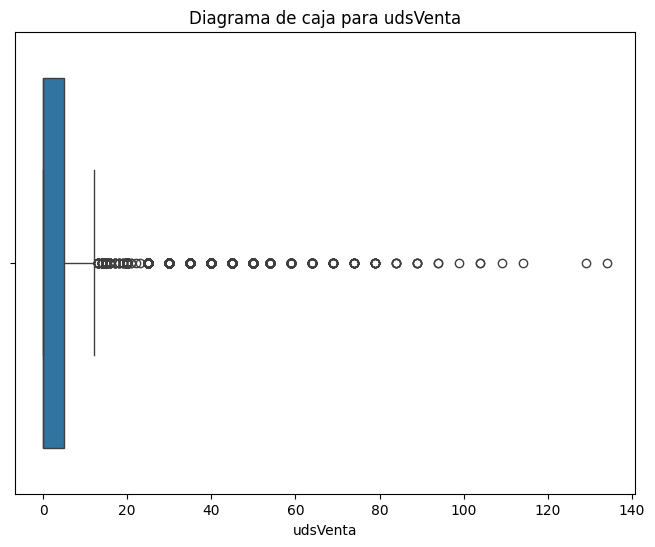

In [ ]:
# Crear un diagrama de caja para identificar outliers en udsVenta
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_ventas_stock_calendario_out['udsVenta'])
plt.title('Diagrama de caja para udsVenta')
plt.xlabel('udsVenta')
plt.show()

Roturas de stock

In [ ]:
data_ventas_stock_calendario_out[(data_ventas_stock_calendario_out['udsVenta'] == 0) & (data_ventas_stock_calendario_out['udsStock'] == 0)]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior
919,2,2021-10-10,0,0,0,1,1,2021,10,10,6,1,40,21.500000,16.118160,69.854480,-26.854480
921,2,2021-10-12,0,0,0,1,1,2021,10,12,1,1,41,21.500000,16.118160,69.854480,-26.854480
926,2,2021-10-17,0,0,0,1,1,2021,10,17,6,2,41,21.500000,16.118160,69.854480,-26.854480
1581,3,2021-08-03,0,0,1,0,1,2021,8,3,1,0,31,25.177419,28.042429,109.304707,-58.949869
1611,3,2021-09-02,0,0,1,0,0,2021,9,2,3,0,35,13.533333,16.768076,63.837560,-36.770894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706218,1000,2022-02-06,0,0,0,1,0,2022,2,6,6,0,5,3.214286,4.515486,16.760743,-10.332171
706271,1000,2022-03-31,0,0,1,0,0,2022,3,31,3,4,13,2.983871,3.993815,14.965315,-8.997573
706272,1000,2022-04-01,0,0,1,0,0,2022,4,1,4,0,13,2.916667,3.828048,14.400812,-8.567479
706273,1000,2022-04-02,0,0,1,0,0,2022,4,2,5,0,13,2.916667,3.828048,14.400812,-8.567479


In [ ]:
import pandas as pd

data_ventas_stock_calendario_out['udsVenta_media'] = data_ventas_stock_calendario_out['udsVenta']

# 1. Filtrar los datos para obtener solo las filas donde udsVenta = udsStock = 0
data_rotura_stock = data_ventas_stock_calendario_out[(data_ventas_stock_calendario_out['udsVenta'] == 0) & (data_ventas_stock_calendario_out['udsStock'] == 0)]

# 2. Agrupar los datos por producto y día de la semana
grouped_data = data_rotura_stock.groupby(['producto', 'dia_semana'])

# 3. Iterar sobre cada grupo
for (producto, dia_semana), group_data in grouped_data:
    # 4. Iterar sobre cada fila del grupo
    for index, row in group_data.iterrows():
        # 5. Obtener la fecha y el día de la semana
        fecha = row['idSecuencia']
        dia_semana = row['dia_semana']

        # 6. Calcular la fecha de inicio y fin de las últimas cuatro semanas
        fecha_inicio = fecha - pd.DateOffset(weeks=4)
        fecha_fin = fecha - pd.DateOffset(weeks=1)

        # 7. Filtrar las ventas de las últimas cuatro semanas para el mismo día de la semana
        ventas_ultimas_semanas = data_ventas_stock_calendario_out[
            (data_ventas_stock_calendario_out['producto'] == producto) &
            (data_ventas_stock_calendario_out['idSecuencia'] >= fecha_inicio) &
            (data_ventas_stock_calendario_out['idSecuencia'] <= fecha_fin) &
            (data_ventas_stock_calendario_out['dia_semana'] == dia_semana)
        ]

        # 8. Calcular la media de las ventas de las últimas cuatro semanas
        media_ventas = ventas_ultimas_semanas['udsVenta'].mean()

        # 9. Asignar la media como el nuevo valor de udsVenta
        data_ventas_stock_calendario_out.at[index, 'udsVenta_media'] = media_ventas


In [ ]:
data_ventas_stock_calendario_out[(data_ventas_stock_calendario_out['udsVenta'] == 0) & (data_ventas_stock_calendario_out['udsStock'] == 0) & (data_ventas_stock_calendario_out['udsVenta_media'] != 0)]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media
921,2,2021-10-12,0,0,0,1,1,2021,10,12,1,1,41,21.500000,16.118160,69.854480,-26.854480,27.50
1581,3,2021-08-03,0,0,1,0,1,2021,8,3,1,0,31,25.177419,28.042429,109.304707,-58.949869,18.75
1611,3,2021-09-02,0,0,1,0,0,2021,9,2,3,0,35,13.533333,16.768076,63.837560,-36.770894,32.25
1612,3,2021-09-03,0,0,1,0,0,2021,9,3,4,0,35,13.533333,16.768076,63.837560,-36.770894,34.75
1613,3,2021-09-04,0,0,1,0,0,2021,9,4,5,0,35,13.533333,16.768076,63.837560,-36.770894,32.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706216,1000,2022-02-04,0,0,1,0,0,2022,2,4,4,0,5,3.214286,4.515486,16.760743,-10.332171,1.25
706217,1000,2022-02-05,0,0,1,0,0,2022,2,5,5,0,5,3.214286,4.515486,16.760743,-10.332171,3.00
706271,1000,2022-03-31,0,0,1,0,0,2022,3,31,3,4,13,2.983871,3.993815,14.965315,-8.997573,3.75
706272,1000,2022-04-01,0,0,1,0,0,2022,4,1,4,0,13,2.916667,3.828048,14.400812,-8.567479,3.25


In [ ]:
data_ventas_stock_calendario_out[(data_ventas_stock_calendario_out['udsVenta'] == 0) & (data_ventas_stock_calendario_out['udsStock'] == 0) & (data_ventas_stock_calendario_out['udsVenta_media'] == 0)]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media
919,2,2021-10-10,0,0,0,1,1,2021,10,10,6,1,40,21.500000,16.118160,69.854480,-26.854480,0.0
926,2,2021-10-17,0,0,0,1,1,2021,10,17,6,2,41,21.500000,16.118160,69.854480,-26.854480,0.0
1614,3,2021-09-05,0,0,0,1,0,2021,9,5,6,0,35,13.533333,16.768076,63.837560,-36.770894,0.0
1658,3,2021-10-19,0,0,1,0,1,2021,10,19,1,2,42,9.903226,13.253777,49.664558,-29.858106,0.0
2386,4,2021-10-17,0,0,0,1,1,2021,10,17,6,2,41,9.274194,11.971509,45.188721,-26.640333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700780,992,2023-03-15,0,0,1,0,0,2023,3,15,2,2,11,2.661290,4.219174,15.318812,-9.996231,0.0
706211,1000,2022-01-30,0,0,0,1,0,2022,1,30,6,4,4,1.532258,2.946060,10.370438,-7.305922,0.0
706212,1000,2022-01-31,0,0,1,0,0,2022,1,31,0,4,5,1.532258,2.946060,10.370438,-7.305922,0.0
706218,1000,2022-02-06,0,0,0,1,0,2022,2,6,6,0,5,3.214286,4.515486,16.760743,-10.332171,0.0


In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['producto'] == 2]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media
730,2,2021-04-04,0,767,0,1,1,2021,4,4,6,0,13,22.483333,17.496238,74.972049,-30.005382,0.0
731,2,2021-04-05,0,767,0,1,1,2021,4,5,0,0,14,22.483333,17.496238,74.972049,-30.005382,0.0
732,2,2021-04-06,40,767,1,0,1,2021,4,6,1,0,14,22.483333,17.496238,74.972049,-30.005382,40.0
733,2,2021-04-07,20,728,1,0,1,2021,4,7,2,1,14,22.483333,17.496238,74.972049,-30.005382,20.0
734,2,2021-04-08,25,708,1,0,0,2021,4,8,3,1,14,22.483333,17.496238,74.972049,-30.005382,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2,2023-03-30,15,554,1,0,0,2023,3,30,3,4,13,18.854839,13.783867,60.206438,-22.496761,15.0
1456,2,2023-03-31,15,545,1,0,0,2023,3,31,4,4,13,18.854839,13.783867,60.206438,-22.496761,15.0
1457,2,2023-04-01,20,535,1,0,0,2023,4,1,5,0,13,22.483333,17.496238,74.972049,-30.005382,20.0
1458,2,2023-04-02,0,515,0,1,0,2023,4,2,6,0,13,22.483333,17.496238,74.972049,-30.005382,0.0


Los que tienen 0 quiere decir que hubo un re-stock

In [ ]:
import numpy as np

# Filtrar las filas donde udsVenta = udsStock = 0 y udsVenta_media != 0 y udsVenta_media no sea NaN
filtered_data = data_ventas_stock_calendario_out[
    (data_ventas_stock_calendario_out['udsVenta'] == 0) &
    (data_ventas_stock_calendario_out['udsStock'] == 0) &
    (~data_ventas_stock_calendario_out['udsVenta_media'].isnull()) &
    (data_ventas_stock_calendario_out['udsVenta_media'] != 0)
]

# Redondear la columna udsVenta_media
filtered_data['udsVenta'] = filtered_data['udsVenta_media'].round().astype(int)

# Mostrar las filas actualizadas
print(filtered_data)

# Actualizar el DataFrame original con los valores modificados
data_ventas_stock_calendario_out.update(filtered_data)


        producto idSecuencia  udsVenta  udsStock  bolOpen  bolHoliday  \
921            2  2021-10-12        28         0        0           1   
1581           3  2021-08-03        19         0        1           0   
1611           3  2021-09-02        32         0        1           0   
1612           3  2021-09-03        35         0        1           0   
1613           3  2021-09-04        32         0        1           0   
...          ...         ...       ...       ...      ...         ...   
706216      1000  2022-02-04         1         0        1           0   
706217      1000  2022-02-05         3         0        1           0   
706271      1000  2022-03-31         4         0        1           0   
706272      1000  2022-04-01         3         0        1           0   
706273      1000  2022-04-02         2         0        1           0   

        estaEnPromocion   año  mes  dia  dia_semana  semana_mes  semana_año  \
921                   1  2021   10   12     

<ipython-input-20-e64e552cb205>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['udsVenta'] = filtered_data['udsVenta_media'].round().astype(int)


In [ ]:
data_ventas_stock_calendario_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706640 entries, 0 to 706639
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   producto                    706640 non-null  int64         
 1   idSecuencia                 706640 non-null  datetime64[ns]
 2   udsVenta                    706640 non-null  int64         
 3   udsStock                    706640 non-null  int64         
 4   bolOpen                     706640 non-null  int64         
 5   bolHoliday                  706640 non-null  int64         
 6   estaEnPromocion             706640 non-null  int64         
 7   año                         706640 non-null  int64         
 8   mes                         706640 non-null  int64         
 9   dia                         706640 non-null  int64         
 10  dia_semana                  706640 non-null  int64         
 11  semana_mes                  706640 non-

In [ ]:
data_ventas_stock_calendario_out.isna().sum()

producto                        0
idSecuencia                     0
udsVenta                        0
udsStock                        0
bolOpen                         0
bolHoliday                      0
estaEnPromocion                 0
año                             0
mes                             0
dia                             0
dia_semana                      0
semana_mes                      0
semana_año                      0
media_ventas                    0
desviacion_estandar_ventas      0
umbral_superior                 0
umbral_inferior                 0
udsVenta_media                163
dtype: int64

In [ ]:
data_ventas_stock_calendario_out[(data_ventas_stock_calendario_out['udsVenta'] == 0) & (data_ventas_stock_calendario_out['udsStock'] == 0) & (data_ventas_stock_calendario_out['udsVenta_media'] != 0)]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media
31390,45,2021-04-04,0,0,0,1,1,2021,4,4,6,0,13,6.416667,6.384015,25.568712,-12.735379,NaN
31391,45,2021-04-05,0,0,0,1,1,2021,4,5,0,0,14,6.416667,6.384015,25.568712,-12.735379,NaN
31392,45,2021-04-06,0,0,1,0,1,2021,4,6,1,0,14,6.416667,6.384015,25.568712,-12.735379,NaN
43070,61,2021-04-04,0,0,0,1,1,2021,4,4,6,0,13,4.250000,5.809475,21.678425,-13.178425,NaN
43071,61,2021-04-05,0,0,0,1,1,2021,4,5,0,0,14,4.250000,5.809475,21.678425,-13.178425,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700072,992,2021-04-06,0,0,1,0,0,2021,4,6,1,0,14,1.583333,3.958649,13.459281,-10.292614,NaN
700073,992,2021-04-07,0,0,1,0,0,2021,4,7,2,1,14,1.583333,3.958649,13.459281,-10.292614,NaN
700074,992,2021-04-08,0,0,1,0,0,2021,4,8,3,1,14,1.583333,3.958649,13.459281,-10.292614,NaN
700075,992,2021-04-09,0,0,1,0,0,2021,4,9,4,1,14,1.583333,3.958649,13.459281,-10.292614,NaN


# **Clustering**

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Seleccionar las columnas deseadas
columnas_deseadas = ['producto', 'udsVenta', 'dia_semana']

features = data_ventas_stock_calendario_out[columnas_deseadas]

# Limpieza de datos: llenar valores faltantes con la media o cero
features.fillna(features.mean(), inplace=True)

# Estandarización de los datos
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

<ipython-input-24-2a2a72d262f1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(features.mean(), inplace=True)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

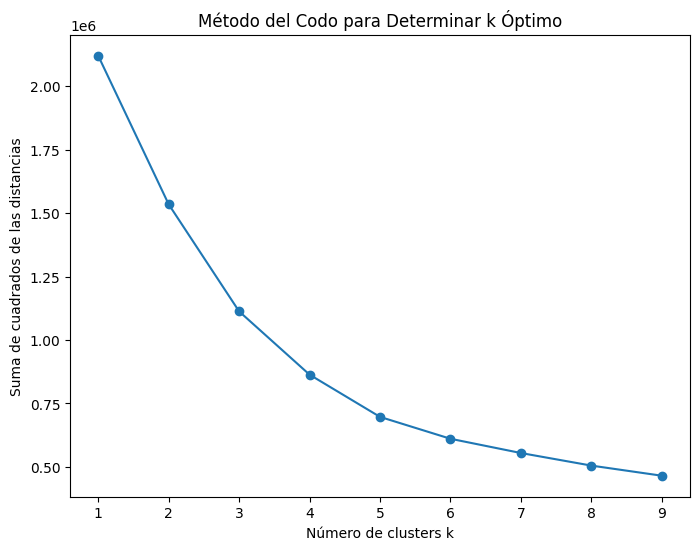

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Método del codo para encontrar el valor óptimo de k
sse = []
list_k = range(1, 10)
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(features_scaled)
    sse.append(km.inertia_)

# Gráfico del método del codo
plt.figure(figsize=(8, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel('Número de clusters k')
plt.ylabel('Suma de cuadrados de las distancias')
plt.title('Método del Codo para Determinar k Óptimo')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


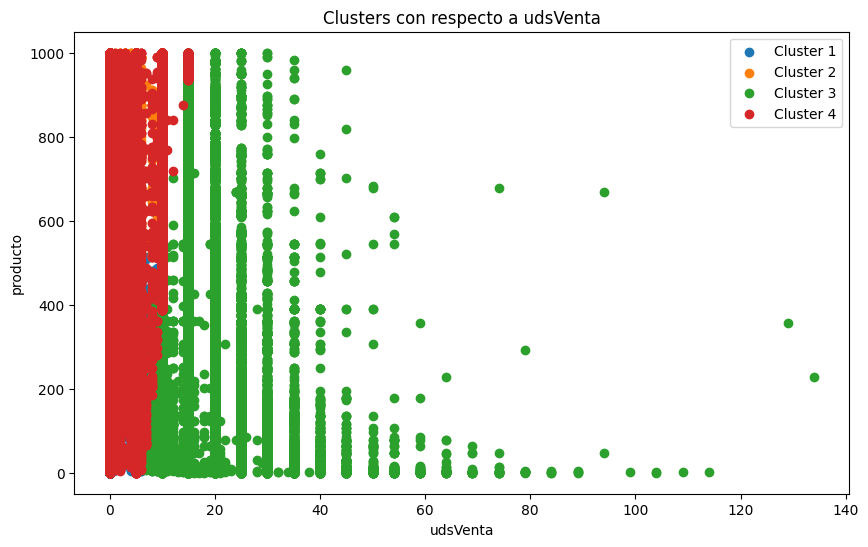

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Ajustar el modelo KMeans con el número óptimo de clusters
k_optimo = 4  # Debes cambiar esto con el valor óptimo determinado por el método del codo
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
kmeans.fit(features_scaled)  # Suponiendo que "features_scaled" es tu conjunto de datos escalados

# Obtener las etiquetas de cluster asignadas a cada punto
cluster_labels = kmeans.labels_

# Agregar las etiquetas de cluster al dataframe original
data_ventas_stock_calendario_out['cluster'] = cluster_labels

# Gráfico de los clusters con respecto a udsVenta
plt.figure(figsize=(10, 6))
for i in range(k_optimo):
    cluster_data = data_ventas_stock_calendario[data_ventas_stock_calendario_out['cluster'] == i]
    plt.scatter(cluster_data['udsVenta'], cluster_data['producto'], label=f'Cluster {i+1}')

plt.xlabel('udsVenta')
plt.ylabel('producto')
plt.title('Clusters con respecto a udsVenta')
plt.legend()
plt.show()


In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['cluster'] == 0]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media,cluster
0,1,2021-04-04,0,604,0,1,1,2021,4,4,6,0,13,24.516667,20.893184,87.196219,-38.162886,0.0,0
7,1,2021-04-11,0,436,0,1,0,2021,4,11,6,1,14,24.516667,20.893184,87.196219,-38.162886,0.0,0
14,1,2021-04-18,0,460,0,1,0,2021,4,18,6,2,15,24.516667,20.893184,87.196219,-38.162886,0.0,0
21,1,2021-04-25,0,312,0,1,0,2021,4,25,6,3,16,24.516667,20.893184,87.196219,-38.162886,0.0,0
27,1,2021-05-01,0,436,0,1,0,2021,5,1,5,0,17,23.919355,17.074858,75.143928,-27.305218,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373688,527,2023-01-22,0,99,0,1,0,2023,1,22,6,3,3,4.435484,5.364183,20.528033,-11.657065,0.0,0
373737,527,2023-03-12,0,40,0,1,0,2023,3,12,6,1,10,3.790323,4.932785,18.588676,-11.008031,0.0,0
373744,527,2023-03-19,0,69,0,1,0,2023,3,19,6,2,11,3.790323,4.932785,18.588676,-11.008031,0.0,0
373751,527,2023-03-26,0,94,0,1,0,2023,3,26,6,3,12,3.790323,4.932785,18.588676,-11.008031,0.0,0


In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['año'] == 2023]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media,cluster
637,1,2023-01-01,0,490,0,1,0,2023,1,1,6,0,52,16.564516,19.951269,76.418324,-43.289292,0.0,0
638,1,2023-01-02,30,490,1,0,0,2023,1,2,0,0,1,16.564516,19.951269,76.418324,-43.289292,30.0,2
639,1,2023-01-03,30,460,1,0,0,2023,1,3,1,0,1,16.564516,19.951269,76.418324,-43.289292,30.0,2
640,1,2023-01-04,0,688,1,0,0,2023,1,4,2,0,1,16.564516,19.951269,76.418324,-43.289292,0.0,0
641,1,2023-01-05,35,688,1,0,0,2023,1,5,3,0,1,16.564516,19.951269,76.418324,-43.289292,35.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706635,1000,2023-03-30,0,109,1,0,0,2023,3,30,3,4,13,2.983871,3.993815,14.965315,-8.997573,0.0,1
706636,1000,2023-03-31,0,109,1,0,0,2023,3,31,4,4,13,2.983871,3.993815,14.965315,-8.997573,0.0,1
706637,1000,2023-04-01,5,109,1,0,0,2023,4,1,5,0,13,2.916667,3.828048,14.400812,-8.567479,5.0,1
706638,1000,2023-04-02,0,109,0,1,0,2023,4,2,6,0,13,2.916667,3.828048,14.400812,-8.567479,0.0,1


In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['cluster'] == 1]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media,cluster
363699,514,2021-09-10,8,0,1,0,0,2021,9,10,4,1,36,1.833333,3.440372,12.154449,-8.487782,7.5,1
365735,517,2021-04-09,5,89,1,0,0,2021,4,9,4,1,14,1.583333,2.836157,10.091804,-6.925137,5.0,1
365742,517,2021-04-16,5,69,1,0,0,2021,4,16,4,2,15,1.583333,2.836157,10.091804,-6.925137,5.0,1
365756,517,2021-04-30,5,109,1,0,0,2021,4,30,4,4,17,1.583333,2.836157,10.091804,-6.925137,5.0,1
365763,517,2021-05-07,5,99,1,0,0,2021,5,7,4,1,18,2.419355,3.592106,13.195673,-8.356963,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706634,1000,2023-03-29,0,109,1,0,0,2023,3,29,2,4,13,2.983871,3.993815,14.965315,-8.997573,0.0,1
706635,1000,2023-03-30,0,109,1,0,0,2023,3,30,3,4,13,2.983871,3.993815,14.965315,-8.997573,0.0,1
706636,1000,2023-03-31,0,109,1,0,0,2023,3,31,4,4,13,2.983871,3.993815,14.965315,-8.997573,0.0,1
706637,1000,2023-04-01,5,109,1,0,0,2023,4,1,5,0,13,2.916667,3.828048,14.400812,-8.567479,5.0,1


Entrenamiento

In [ ]:
data_ventas_stock_calendario_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706640 entries, 0 to 706639
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   producto                    706640 non-null  int64         
 1   idSecuencia                 706640 non-null  datetime64[ns]
 2   udsVenta                    706640 non-null  int64         
 3   udsStock                    706640 non-null  int64         
 4   bolOpen                     706640 non-null  int64         
 5   bolHoliday                  706640 non-null  int64         
 6   estaEnPromocion             706640 non-null  int64         
 7   año                         706640 non-null  int64         
 8   mes                         706640 non-null  int64         
 9   dia                         706640 non-null  int64         
 10  dia_semana                  706640 non-null  int64         
 11  semana_mes                  706640 non-

# **Entrenamiento**

In [ ]:
columnas_deseadas = ['producto', 'idSecuencia', 'udsVenta', 'bolOpen', 'bolHoliday', 'estaEnPromocion', 'año', 'mes', 'dia', 'dia_semana', 'semana_mes', 'semana_año', 'cluster']
data_ventas_stock_calendario_out_red = data_ventas_stock_calendario_out[columnas_deseadas]

In [ ]:
data_ventas_stock_calendario_out_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706640 entries, 0 to 706639
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   producto         706640 non-null  int64         
 1   idSecuencia      706640 non-null  datetime64[ns]
 2   udsVenta         706640 non-null  int64         
 3   bolOpen          706640 non-null  int64         
 4   bolHoliday       706640 non-null  int64         
 5   estaEnPromocion  706640 non-null  int64         
 6   año              706640 non-null  int64         
 7   mes              706640 non-null  int64         
 8   dia              706640 non-null  int64         
 9   dia_semana       706640 non-null  int64         
 10  semana_mes       706640 non-null  int64         
 11  semana_año       706640 non-null  int64         
 12  cluster          706640 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(11)
memory usage: 67.4 MB


In [ ]:
train = data_ventas_stock_calendario_out_red[data_ventas_stock_calendario_out_red['idSecuencia'] <= '2022-12-31']
# Validación: desde 2023-01-01 hasta 2023-02-28
validation = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-01-01') & (data_ventas_stock_calendario_out_red['idSecuencia'] <= '2023-02-28')]
# Prueba: desde 2023-03-01 hasta 2023-04-03
test = data_ventas_stock_calendario_out_red[data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-03-01']

# Verificar los tamaños de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(train))
print("Tamaño del conjunto de validación:", len(validation))
print("Tamaño del conjunto de prueba:", len(test))

Tamaño del conjunto de entrenamiento: 616616
Tamaño del conjunto de validación: 57112
Tamaño del conjunto de prueba: 32912


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Inicializar y entrenar el modelo Random Forest
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

# Hacer predicciones en el conjunto de validación
predicciones_validacion = modelo_rf.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = modelo_rf.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


Error cuadrático medio en el conjunto de validación: 12.312679344095812
Error cuadrático medio en el conjunto de prueba: 11.51222860354886


In [ ]:
# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


RMSE val: 3.508942767287009
RMSE test: 3.392967521735046


In [ ]:
from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

Explained Variance Score: 0.5832853470241519


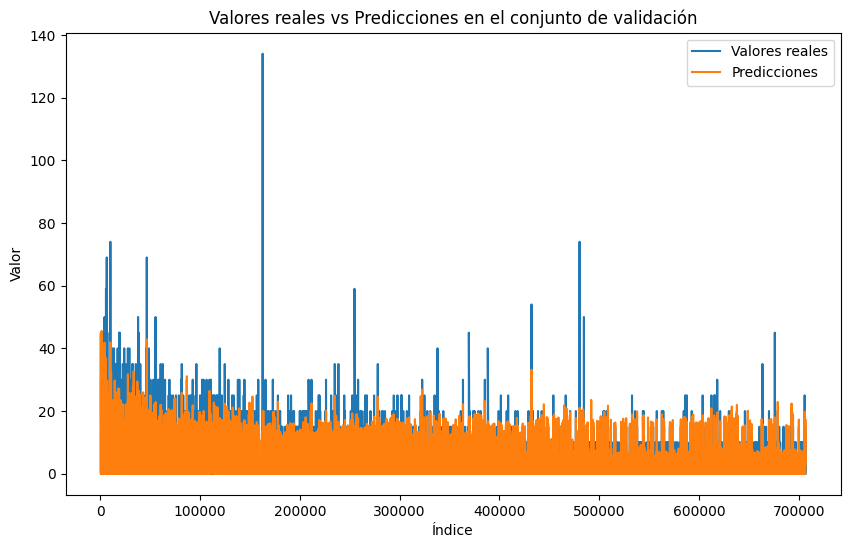

In [ ]:
import matplotlib.pyplot as plt

# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_validation.index, y_validation, label='Valores reales')
plt.plot(y_validation.index, predicciones_validacion, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Calcular el coeficiente de determinación para el conjunto de validación
r2_validation = r2_score(y_validation, predicciones_validacion)
print("Coeficiente de determinación en el conjunto de validación:", r2_validation)

# Calcular el coeficiente de determinación para el conjunto de prueba
r2_test = r2_score(y_test, predicciones_prueba)
print("Coeficiente de determinación en el conjunto de prueba:", r2_test)


Coeficiente de determinación en el conjunto de validación: 0.6050163364073853
Coeficiente de determinación en el conjunto de prueba: 0.5812947075234303


Ahora con diferentes hiperparametros

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Definir el rango de hiperparámetros a probar
param_grid = {
    'n_estimators': [250, 500],
    'max_depth': [2, 4, 6]
}

# Inicializar el modelo RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el mejor modelo
best_rf_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de prueba usando el mejor modelo
predicciones = best_rf_model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse = mean_squared_error(y_test, predicciones)
print("Error cuadrático medio en el conjunto de prueba:", mse)


Mejores hiperparámetros: {'max_depth': 6, 'n_estimators': 250}
Error cuadrático medio en el conjunto de prueba: 9.941404573500305


In [ ]:
# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


RMSE val: 3.508942767287009
RMSE test: 3.392967521735046


In [ ]:
from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones)

print("Explained Variance Score:", evs)

Explained Variance Score: 0.6395629655677985


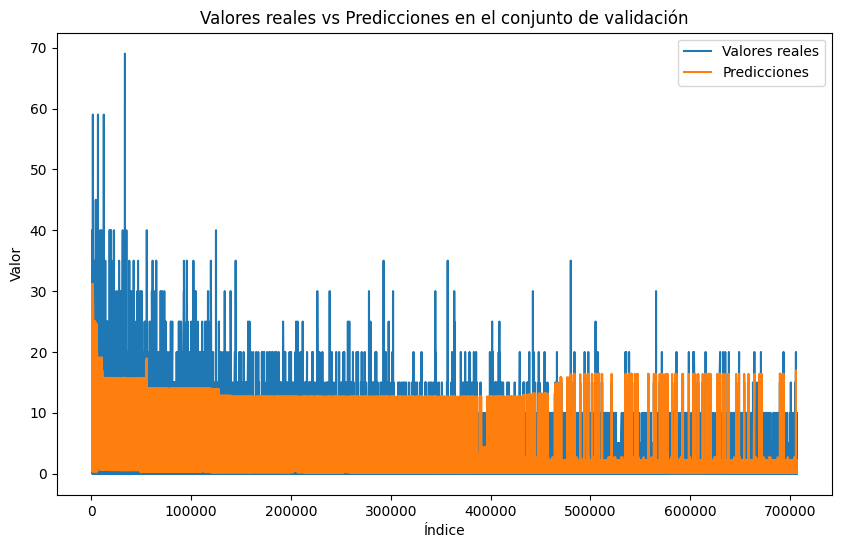

In [ ]:
import matplotlib.pyplot as plt

# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_test.index, y_test, label='Valores reales')
plt.plot(y_test.index, predicciones, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Calcular el coeficiente de determinación para el conjunto de validación
r2_validation = r2_score(y_validation, predicciones_validacion)
print("Coeficiente de determinación en el conjunto de validación:", r2_validation)

# Calcular el coeficiente de determinación para el conjunto de prueba
r2_test = r2_score(y_test, predicciones)
print("Coeficiente de determinación en el conjunto de prueba:", r2_test)


Coeficiente de determinación en el conjunto de validación: 0.6050163364073853
Coeficiente de determinación en el conjunto de prueba: 0.6384263331695672


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Inicializar y entrenar el modelo Random Forest
modelo_rf = RandomForestRegressor(n_estimators=4000, random_state=42, max_depth=6)
modelo_rf.fit(X_train, y_train)

# Hacer predicciones en el conjunto de validación
predicciones_validacion = modelo_rf.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = modelo_rf.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


Error cuadrático medio en el conjunto de validación: 10.955211334287695
Error cuadrático medio en el conjunto de prueba: 9.937989719192538


In [ ]:
# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


RMSE val: 3.309865757744216
RMSE test: 3.152457726789138


In [ ]:
from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones)

print("Explained Variance Score:", evs)

Explained Variance Score: 0.6395629655677985


In [ ]:
import matplotlib.pyplot as plt

# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_test.index, y_test, label='Valores reales')
plt.plot(y_test.index, predicciones, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


NameError: name 'y_test' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
from sklearn.metrics import r2_score

# Calcular el coeficiente de determinación para el conjunto de validación
r2_validation = r2_score(y_validation, predicciones_validacion)
print("Coeficiente de determinación en el conjunto de validación:", r2_validation)

# Calcular el coeficiente de determinación para el conjunto de prueba
r2_test = r2_score(y_test, predicciones)
print("Coeficiente de determinación en el conjunto de prueba:", r2_test)


Coeficiente de determinación en el conjunto de validación: 0.648563128518145
Coeficiente de determinación en el conjunto de prueba: 0.6384263331695672


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Asegúrate de que tus datos estén en un formato adecuado para LSTM
# (número de muestras, número de pasos de tiempo, número de características)
# Esto puede requerir remodelar tus datos si aún no están en este formato

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']



# Remodelar los datos de entrenamiento y prueba
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation))

# Hacer predicciones en el conjunto de validación
predicciones_validacion = model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


Epoch 1/10
19270/19270 [==============================] - 40s 2ms/step - loss: 23.7017 - val_loss: 21.3867
Epoch 2/10
19270/19270 [==============================] - 39s 2ms/step - loss: 15.0975 - val_loss: 19.7107
Epoch 3/10
19270/19270 [==============================] - 39s 2ms/step - loss: 13.3679 - val_loss: 21.9463
Epoch 4/10
19270/19270 [==============================] - 39s 2ms/step - loss: 13.1570 - val_loss: 15.3154
Epoch 5/10
19270/19270 [==============================] - 40s 2ms/step - loss: 13.0875 - val_loss: 16.0851
Epoch 6/10
19270/19270 [==============================] - 39s 2ms/step - loss: 13.0216 - val_loss: 19.7594
Epoch 7/10
19270/19270 [==============================] - 38s 2ms/step - loss: 12.9995 - val_loss: 15.2990
Epoch 8/10
19270/19270 [==============================] - 39s 2ms/step - loss: 12.9071 - val_loss: 17.5808
Epoch 9/10
19270/19270 [==============================] - 39s 2ms/step - loss: 12.9064 - val_loss: 16.7729
Epoch 10/10
1785/1785 [==============

In [ ]:
# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


RMSE val: 4.147348567810583
RMSE test: 3.7909204988827687


In [ ]:
from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

Explained Variance Score: 0.49120550208776015


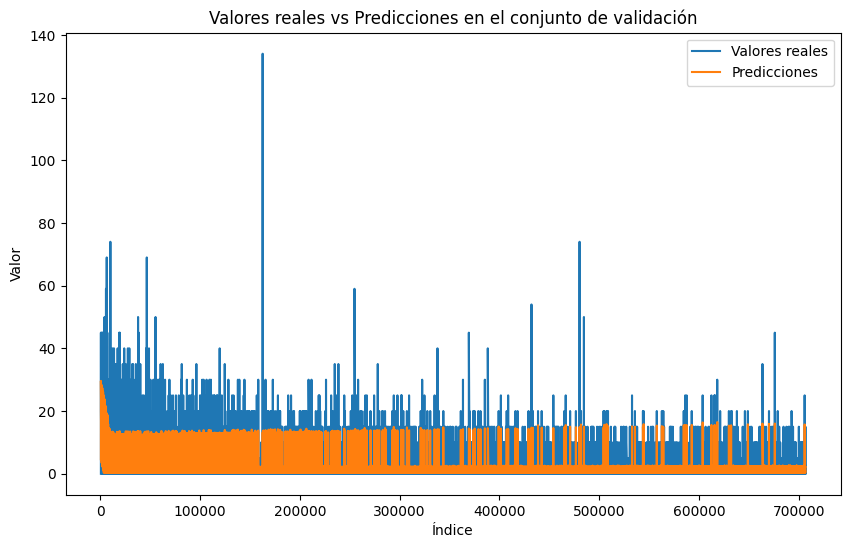

In [ ]:
import matplotlib.pyplot as plt

# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_validation.index, y_validation, label='Valores reales')
plt.plot(y_validation.index, predicciones_validacion, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Calcular el coeficiente de determinación para el conjunto de validación
r2_validation = r2_score(y_validation, predicciones_validacion)
print("Coeficiente de determinación en el conjunto de validación:", r2_validation)

# Calcular el coeficiente de determinación para el conjunto de prueba
r2_test = r2_score(y_test, predicciones_prueba)
print("Coeficiente de determinación en el conjunto de prueba:", r2_test)


Coeficiente de determinación en el conjunto de validación: 0.44514534928603
Coeficiente de determinación en el conjunto de prueba: 0.47528478781167516


In [ ]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 3.0 MB/s eta 0:00:00


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Inicializar el modelo XGBoost con los parámetros dados
modelo_xgb = XGBRegressor(n_estimators=500, max_depth=7, min_samples_split=5, learning_rate=0.01, random_state=42)

# Ajustar el modelo con los datos de entrenamiento
modelo_xgb.fit(X_train, y_train)

# Hacer predicciones en el conjunto de validación
predicciones_validacion = modelo_xgb.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = modelo_xgb.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:14:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Error cuadrático medio en el conjunto de validación: 15.318263655013444
Error cuadrático medio en el conjunto de prueba: 13.502046426600012


In [ ]:
# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


RMSE val: 3.9138553441604667
RMSE test: 3.674513087008946


In [ ]:
from sklearn.metrics import r2_score

# Calcular el coeficiente de determinación para el conjunto de validación
r2_validation = r2_score(y_validation, predicciones_validacion)
print("Coeficiente de determinación en el conjunto de validación:", r2_validation)

# Calcular el coeficiente de determinación para el conjunto de prueba
r2_test = r2_score(y_test, predicciones_prueba)
print("Coeficiente de determinación en el conjunto de prueba:", r2_test)


Coeficiente de determinación en el conjunto de validación: 0.5058626342708276
Coeficiente de determinación en el conjunto de prueba: 0.5070147804576262


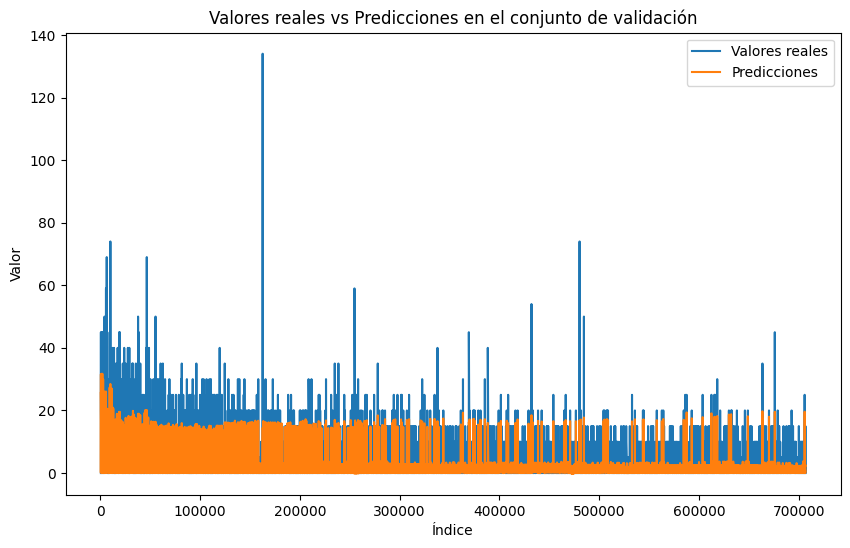

In [ ]:
import matplotlib.pyplot as plt

# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_validation.index, y_validation, label='Valores reales')
plt.plot(y_validation.index, predicciones_validacion, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

Explained Variance Score: 0.5160034797935729


In [ ]:
datos_entrenamiento_v2 = datos_entrenamiento.apply(pd.to_numeric, errors='coerce')
datos_prueba_v2 = datos_prueba.apply(pd.to_numeric, errors='coerce')

# **Entrenamiento RNN**

In [ ]:
columnas_deseadas = ['producto', 'idSecuencia', 'udsVenta', 'bolOpen', 'bolHoliday', 'estaEnPromocion', 'año', 'mes', 'dia', 'dia_semana', 'semana_mes', 'semana_año', 'cluster']
data_ventas_stock_calendario_out_red = data_ventas_stock_calendario_out[columnas_deseadas]

In [ ]:
train = data_ventas_stock_calendario_out_red[data_ventas_stock_calendario_out_red['idSecuencia'] <= '2022-12-31']
# Validación: desde 2023-01-01 hasta 2023-02-28
validation = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-01-01') & (data_ventas_stock_calendario_out_red['idSecuencia'] <= '2023-02-28')]
# Prueba: desde 2023-03-01 hasta 2023-04-03
test = data_ventas_stock_calendario_out_red[data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-03-01']

# Verificar los tamaños de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(train))
print("Tamaño del conjunto de validación:", len(validation))
print("Tamaño del conjunto de prueba:", len(test))

Tamaño del conjunto de entrenamiento: 616616
Tamaño del conjunto de validación: 57112
Tamaño del conjunto de prueba: 32912


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Asegúrate de que tus datos estén en un formato adecuado para LSTM
# (número de muestras, número de pasos de tiempo, número de características)
# Esto puede requerir remodelar tus datos si aún no están en este formato

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']



# Remodelar los datos de entrenamiento y prueba
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation))

# Hacer predicciones en el conjunto de validación
predicciones_validacion = model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


Epoch 1/10
19270/19270 [==============================] - 42s 2ms/step - loss: 32.0484 - val_loss: 25.5695
Epoch 2/10
19270/19270 [==============================] - 40s 2ms/step - loss: 25.1350 - val_loss: 23.5893
Epoch 3/10
19270/19270 [==============================] - 40s 2ms/step - loss: 23.7199 - val_loss: 20.2821
Epoch 4/10
19270/19270 [==============================] - 40s 2ms/step - loss: 19.9275 - val_loss: 18.3593
Epoch 5/10
19270/19270 [==============================] - 39s 2ms/step - loss: 16.4187 - val_loss: 15.7821
Epoch 6/10
19270/19270 [==============================] - 38s 2ms/step - loss: 14.5775 - val_loss: 13.6562
Epoch 7/10
19270/19270 [==============================] - 41s 2ms/step - loss: 14.0485 - val_loss: 12.8800
Epoch 8/10
19270/19270 [==============================] - 39s 2ms/step - loss: 13.8789 - val_loss: 13.1217
Epoch 9/10
19270/19270 [==============================] - 41s 2ms/step - loss: 13.8075 - val_loss: 15.1972
Epoch 10/10
1785/1785 [==============

In [ ]:
# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


RMSE val: 3.990928176063636
RMSE test: 3.776509432726069


In [ ]:
from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

Explained Variance Score: 0.5481724583670748


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Asegúrate de que tus datos estén en un formato adecuado para LSTM
# (número de muestras, número de pasos de tiempo, número de características)
# Esto puede requerir remodelar tus datos si aún no están en este formato

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']



# Remodelar los datos de entrenamiento y prueba
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=20, validation_data=(X_validation, y_validation))

# Hacer predicciones en el conjunto de validación
predicciones_validacion = model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


Epoch 1/20
19270/19270 [==============================] - 47s 2ms/step - loss: 25.9836 - val_loss: 22.2053
Epoch 2/20
19270/19270 [==============================] - 46s 2ms/step - loss: 20.0095 - val_loss: 18.1657
Epoch 3/20
19270/19270 [==============================] - 45s 2ms/step - loss: 17.8024 - val_loss: 16.3260
Epoch 4/20
19270/19270 [==============================] - 45s 2ms/step - loss: 16.4662 - val_loss: 16.4013
Epoch 5/20
19270/19270 [==============================] - 44s 2ms/step - loss: 14.0582 - val_loss: 13.7807
Epoch 6/20
19270/19270 [==============================] - 46s 2ms/step - loss: 13.1163 - val_loss: 12.2581
Epoch 7/20
19270/19270 [==============================] - 46s 2ms/step - loss: 12.9948 - val_loss: 12.3721
Epoch 8/20
19270/19270 [==============================] - 45s 2ms/step - loss: 12.9073 - val_loss: 11.8805
Epoch 9/20
19270/19270 [==============================] - 47s 2ms/step - loss: 12.8486 - val_loss: 12.1483
Epoch 10/20
19270/19270 [============

In [ ]:
# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


RMSE val: 3.4742487577600785
RMSE test: 3.2943858713769814


In [ ]:
from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

Explained Variance Score: 0.611874587698827


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Asegúrate de que tus datos estén en un formato adecuado para LSTM
# (número de muestras, número de pasos de tiempo, número de características)
# Esto puede requerir remodelar tus datos si aún no están en este formato

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']



# Remodelar los datos de entrenamiento y prueba
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=200, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, validation_data=(X_validation, y_validation))

# Hacer predicciones en el conjunto de validación
predicciones_validacion = model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


Epoch 1/50
19270/19270 [==============================] - 151s 8ms/step - loss: 25.5658 - val_loss: 23.5293
Epoch 2/50
19270/19270 [==============================] - 145s 8ms/step - loss: 21.6554 - val_loss: 18.7992
Epoch 3/50
19270/19270 [==============================] - 141s 7ms/step - loss: 17.7284 - val_loss: 15.5428
Epoch 4/50
19270/19270 [==============================] - 149s 8ms/step - loss: 15.3905 - val_loss: 18.5069
Epoch 5/50
19270/19270 [==============================] - 146s 8ms/step - loss: 14.3761 - val_loss: 15.7246
Epoch 6/50
19270/19270 [==============================] - 132s 7ms/step - loss: 14.0905 - val_loss: 15.8163
Epoch 7/50
19270/19270 [==============================] - 133s 7ms/step - loss: 13.9423 - val_loss: 13.9112
Epoch 8/50
19270/19270 [==============================] - 137s 7ms/step - loss: 13.8428 - val_loss: 13.6643
Epoch 9/50
19270/19270 [==============================] - 133s 7ms/step - loss: 13.7517 - val_loss: 13.4136
Epoch 10/50
19270/19270 [===

In [ ]:
# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


RMSE val: 3.614058230706216
RMSE test: 3.4049341425670776


In [ ]:
from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

Explained Variance Score: 0.5838708197761857


# **XGboost**

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Definir el rango de hiperparámetros a probar
param_grid = {
    'n_estimators': [250, 500, 1000],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'gamma': [0, 0.1, 0.2]
}

# Inicializar el modelo XGBoost
modelo_xgb = XGBRegressor(random_state=42)

# Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
grid_search = GridSearchCV(estimator=modelo_xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
predicciones_validacion = best_model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = best_model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500}
Error cuadrático medio en el conjunto de validación: 10.695816299758132
Error cuadrático medio en el conjunto de prueba: 9.726468745523498
RMSE val: 3.2704458869943305
RMSE test: 3.1187287066244633
Explained Variance Score: 0.6469516316140164


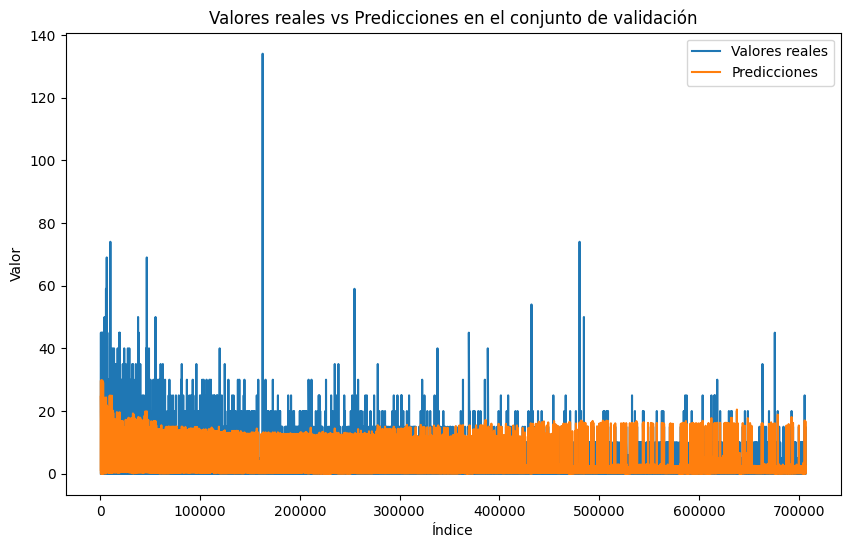

In [ ]:
import matplotlib.pyplot as plt

# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_validation.index, y_validation, label='Valores reales')
plt.plot(y_validation.index, predicciones_validacion, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Definir el rango de hiperparámetros a probar
param_grid = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'gamma': [0, 0.1, 0.2]
}

# Inicializar el modelo XGBoost
modelo_xgb = XGBRegressor(random_state=42)

# Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
grid_search = GridSearchCV(estimator=modelo_xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
predicciones_validacion = best_model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = best_model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mejores hiperparámetros: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500}
Error cuadrático medio en el conjunto de validación: 10.695816299758132
Error cuadrático medio en el conjunto de prueba: 9.726468745523498
RMSE val: 3.2704458869943305
RMSE test: 3.1187287066244633
Explained Variance Score: 0.6469516316140164


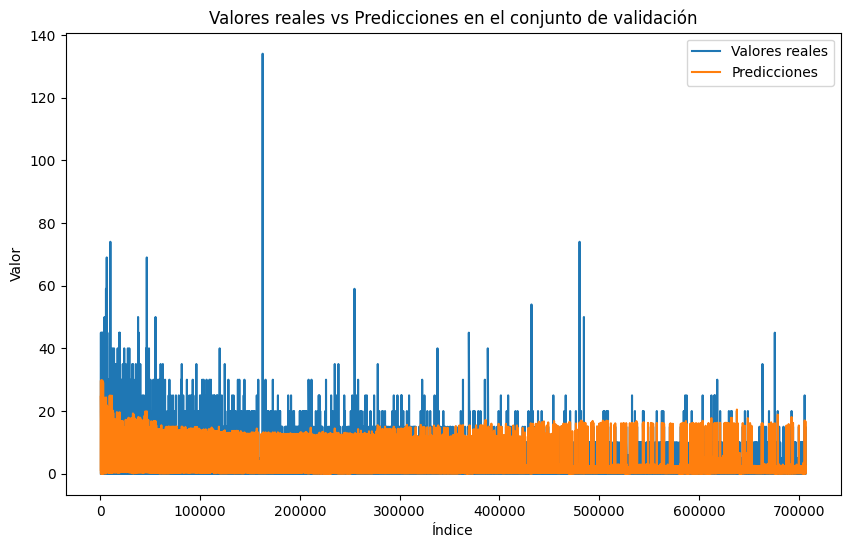

In [ ]:
import matplotlib.pyplot as plt

# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_validation.index, y_validation, label='Valores reales')
plt.plot(y_validation.index, predicciones_validacion, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error


# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Inicializar el modelo Naive Bayes Gaussiano
modelo_nb = GaussianNB()

# Ajustar el modelo Naive Bayes a los datos de entrenamiento
modelo_nb.fit(X_train, y_train)

# Hacer predicciones en el conjunto de validación
predicciones_validacion = modelo_nb.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = modelo_nb.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)

# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


Error cuadrático medio en el conjunto de validación: 73.22464630900686
Error cuadrático medio en el conjunto de prueba: 104.05596742829363
RMSE val: 8.557140077678223
RMSE test: 10.200782687043853


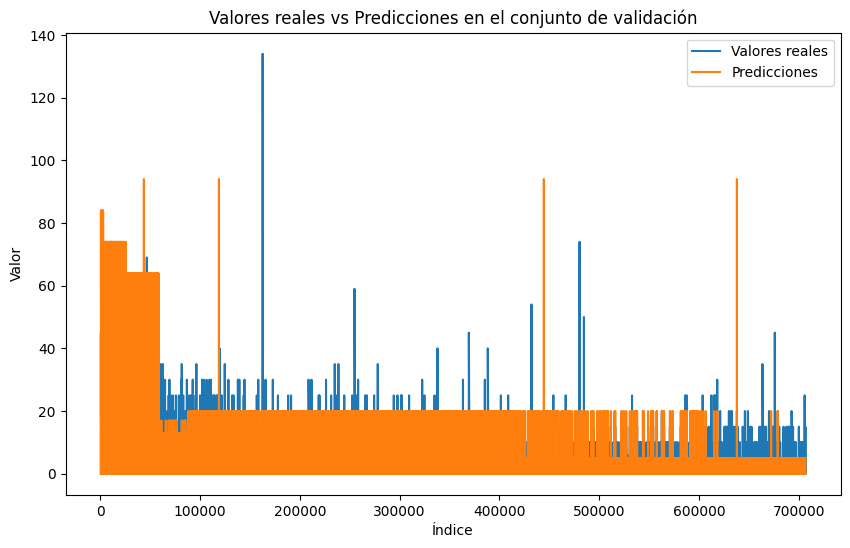

In [ ]:
import matplotlib.pyplot as plt

# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_validation.index, y_validation, label='Valores reales')
plt.plot(y_validation.index, predicciones_validacion, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

Explained Variance Score: -2.1693223467019984


# **Probar quitando dia, semana, año.**

In [ ]:
columnas_deseadas = ['producto', 'idSecuencia', 'udsVenta', 'bolOpen', 'bolHoliday', 'estaEnPromocion', 'dia_semana', 'semana_mes', 'semana_año', 'cluster']
data_ventas_stock_calendario_out_red = data_ventas_stock_calendario_out[columnas_deseadas]

In [ ]:
train = data_ventas_stock_calendario_out_red[data_ventas_stock_calendario_out_red['idSecuencia'] <= '2022-12-31']
# Validación: desde 2023-01-01 hasta 2023-02-28
validation = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-01-01') & (data_ventas_stock_calendario_out_red['idSecuencia'] <= '2023-02-28')]
# Prueba: desde 2023-03-01 hasta 2023-04-03
test = data_ventas_stock_calendario_out_red[data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-03-01']

# Verificar los tamaños de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(train))
print("Tamaño del conjunto de validación:", len(validation))
print("Tamaño del conjunto de prueba:", len(test))

Tamaño del conjunto de entrenamiento: 616616
Tamaño del conjunto de validación: 57112
Tamaño del conjunto de prueba: 32912


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Definir el rango de hiperparámetros a probar
param_grid = {
    'n_estimators': [250, 500],
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'gamma': [0, 0.1, 0.2]
}

# Inicializar el modelo XGBoost
modelo_xgb = XGBRegressor(random_state=42)

# Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
grid_search = GridSearchCV(estimator=modelo_xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de validación
predicciones_validacion = best_model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = best_model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}
Error cuadrático medio en el conjunto de validación: 10.689191353097941
Error cuadrático medio en el conjunto de prueba: 9.73022622642666
RMSE val: 3.26943287943
RMSE test: 3.1193310543170405
Explained Variance Score: 0.646960145274837


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Asegúrate de que tus datos estén en un formato adecuado para LSTM
# (número de muestras, número de pasos de tiempo, número de características)
# Esto puede requerir remodelar tus datos si aún no están en este formato

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']



# Remodelar los datos de entrenamiento y prueba
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation))

# Hacer predicciones en el conjunto de validación
predicciones_validacion = model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)


Epoch 1/10
19270/19270 [==============================] - 69s 4ms/step - loss: 17.7240 - val_loss: 13.3226
Epoch 2/10
19270/19270 [==============================] - 65s 3ms/step - loss: 13.0084 - val_loss: 12.3749
Epoch 3/10
19270/19270 [==============================] - 70s 4ms/step - loss: 12.4574 - val_loss: 12.2629
Epoch 4/10
19270/19270 [==============================] - 68s 4ms/step - loss: 12.2601 - val_loss: 14.6788
Epoch 5/10
19270/19270 [==============================] - 62s 3ms/step - loss: 12.2500 - val_loss: 12.4228
Epoch 6/10
19270/19270 [==============================] - 63s 3ms/step - loss: 12.7985 - val_loss: 14.9726
Epoch 7/10
19270/19270 [==============================] - 63s 3ms/step - loss: 12.1100 - val_loss: 11.5678
Epoch 8/10
19270/19270 [==============================] - 65s 3ms/step - loss: 12.0230 - val_loss: 11.3159
Epoch 9/10
19270/19270 [==============================] - 63s 3ms/step - loss: 12.2194 - val_loss: 11.6824
Epoch 10/10
1785/1785 [==============

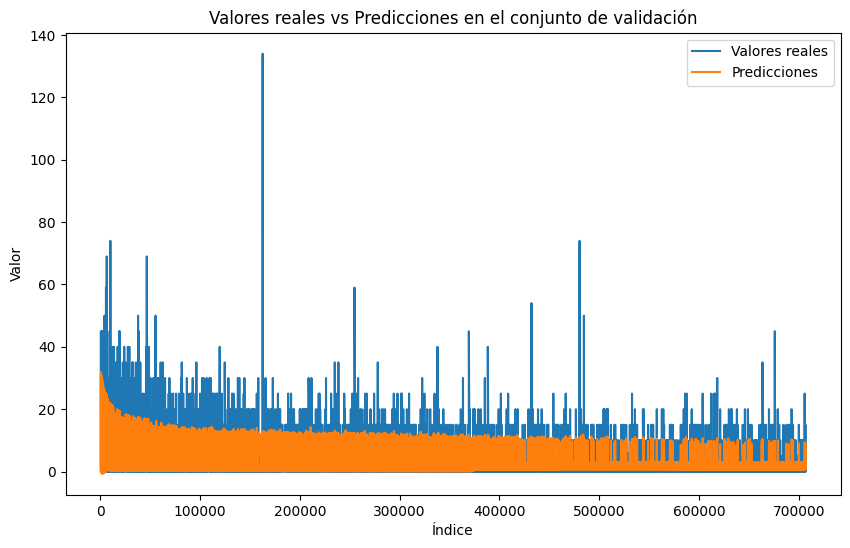

In [ ]:
import matplotlib.pyplot as plt

# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_validation.index, y_validation, label='Valores reales')
plt.plot(y_validation.index, predicciones_validacion, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
# Crear un DataFrame con los valores reales y las predicciones
data = pd.DataFrame({
    'Real_Values': y_test,
    'Predicted_Values': predicciones_prueba.flatten()  # Usar flatten() si las predicciones son en forma de array 2D
})

# Mostrar las primeras filas del DataFrame
print(data.head())


     Real_Values  Predicted_Values
696           20         29.529213
697           10         31.010365
698           30         32.050114
699           25         32.836464
700            0          1.174260


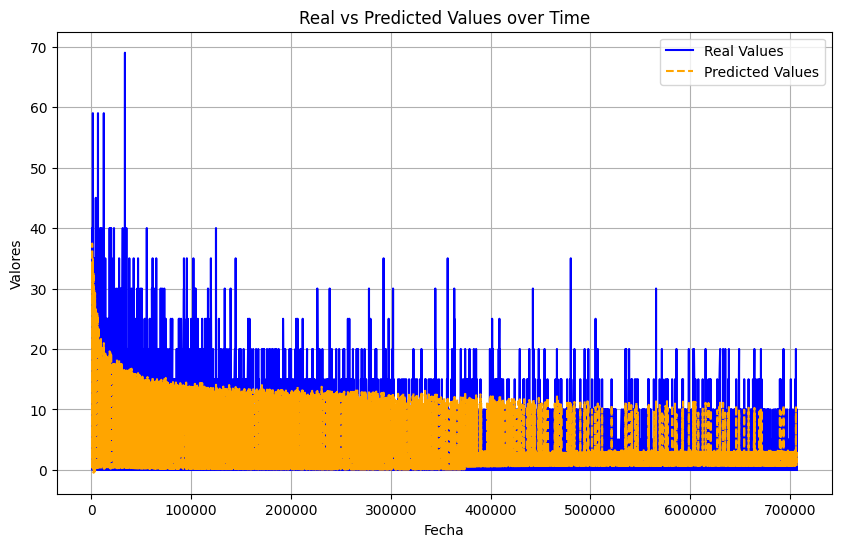

In [ ]:
# Graficar las series temporales de valores reales y predichos
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Real_Values'], label='Real Values', color='blue')
plt.plot(data.index, data['Predicted_Values'], label='Predicted Values', linestyle='--', color='orange')

# Personalizar el gráfico
plt.title('Real vs Predicted Values over Time')
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Asegúrate de que tus datos estén en un formato adecuado para LSTM
# (número de muestras, número de pasos de tiempo, número de características)
# Esto puede requerir remodelar tus datos si aún no están en este formato

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']



# Remodelar los datos de entrenamiento y prueba
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=200, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=20, validation_data=(X_validation, y_validation))

# Hacer predicciones en el conjunto de validación
predicciones_validacion = model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)


Epoch 1/20
19270/19270 [==============================] - 142s 7ms/step - loss: 17.0292 - val_loss: 12.9060
Epoch 2/20
19270/19270 [==============================] - 139s 7ms/step - loss: 12.8864 - val_loss: 12.0432
Epoch 3/20
19270/19270 [==============================] - 134s 7ms/step - loss: 12.4798 - val_loss: 12.7906
Epoch 4/20
19270/19270 [==============================] - 136s 7ms/step - loss: 12.1730 - val_loss: 13.4567
Epoch 5/20
19270/19270 [==============================] - 136s 7ms/step - loss: 12.3056 - val_loss: 14.0574
Epoch 6/20
19270/19270 [==============================] - 135s 7ms/step - loss: 12.0396 - val_loss: 11.6019
Epoch 7/20
19270/19270 [==============================] - 137s 7ms/step - loss: 12.1447 - val_loss: 12.1248
Epoch 8/20
19270/19270 [==============================] - 136s 7ms/step - loss: 12.4277 - val_loss: 12.5967
Epoch 9/20
19270/19270 [==============================] - 134s 7ms/step - loss: 12.1730 - val_loss: 12.0192
Epoch 10/20
19270/19270 [===

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Asegúrate de que tus datos estén en un formato adecuado para LSTM
# (número de muestras, número de pasos de tiempo, número de características)
# Esto puede requerir remodelar tus datos si aún no están en este formato

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_validation = validation.drop(['udsVenta', 'idSecuencia'], axis=1)
y_validation = validation['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']



# Remodelar los datos de entrenamiento y prueba
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=500, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, validation_data=(X_validation, y_validation))

# Hacer predicciones en el conjunto de validación
predicciones_validacion = model.predict(X_validation)

# Calcular el error cuadrático medio en el conjunto de validación
mse_validation = mean_squared_error(y_validation, predicciones_validacion)
print("Error cuadrático medio en el conjunto de validación:", mse_validation)

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


# Calcular el RMSE
rmse_validation = np.sqrt(mse_validation)
print("RMSE val:", rmse_validation)

rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)


Epoch 1/50
19270/19270 [==============================] - 423s 22ms/step - loss: 16.6327 - val_loss: 12.8202
Epoch 2/50
19270/19270 [==============================] - 422s 22ms/step - loss: 12.8516 - val_loss: 12.8061
Epoch 3/50
19270/19270 [==============================] - 427s 22ms/step - loss: 12.3362 - val_loss: 12.0145
Epoch 4/50
19270/19270 [==============================] - 422s 22ms/step - loss: 12.1779 - val_loss: 11.4230
Epoch 5/50
19270/19270 [==============================] - 419s 22ms/step - loss: 12.0647 - val_loss: 12.0126
Epoch 6/50
19270/19270 [==============================] - 424s 22ms/step - loss: 12.0035 - val_loss: 11.3612
Epoch 7/50
19270/19270 [==============================] - 416s 22ms/step - loss: 11.9249 - val_loss: 11.3779
Epoch 8/50
19270/19270 [==============================] - 420s 22ms/step - loss: 11.9368 - val_loss: 11.5658
Epoch 9/50
19270/19270 [==============================] - 419s 22ms/step - loss: 11.8397 - val_loss: 11.3157
Epoch 10/50
19270/1

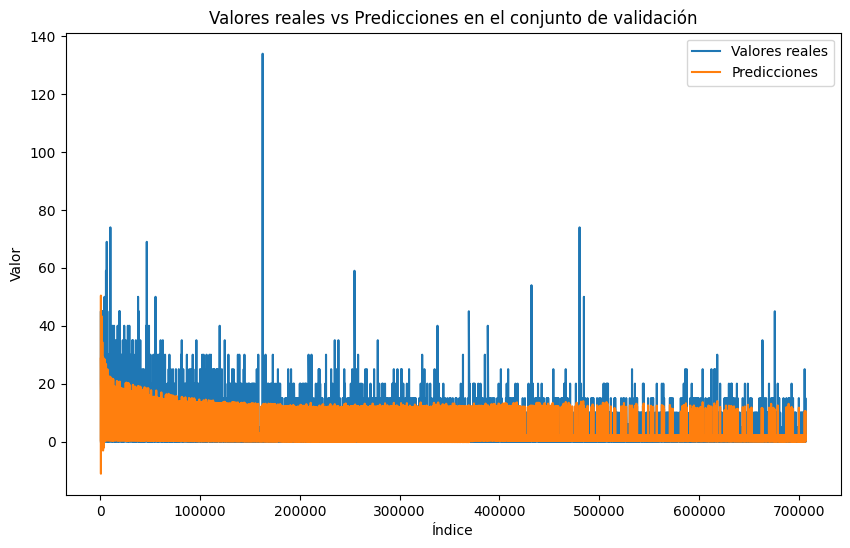

In [ ]:
import matplotlib.pyplot as plt

# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_validation.index, y_validation, label='Valores reales')
plt.plot(y_validation.index, predicciones_validacion, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de validación')
plt.legend()

# Mostrar el gráfico
plt.show()


Guardar resultados

In [ ]:
ruta_pred_test = "/content/drive/Othercomputers/Mi portátil/UOC/4o Semestre/TFM/Datos/test_preds.csv"
pd.DataFrame(predicciones_prueba).to_csv(ruta_pred_test)
ruta_pred_val = "/content/drive/Othercomputers/Mi portátil/UOC/4o Semestre/TFM/Datos/val_preds.csv"
pd.DataFrame(predicciones_validacion).to_csv(ruta_pred_val)


# **Probar con modelo por cluster**

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Seleccionar las columnas deseadas
columnas_deseadas = ['producto', 'udsVenta']

features = data_ventas_stock_calendario_out[columnas_deseadas]

# Limpieza de datos: llenar valores faltantes con la media o cero
features.fillna(features.mean(), inplace=True)

# Estandarización de los datos
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

<ipython-input-24-6f16fb184b7b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(features.mean(), inplace=True)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

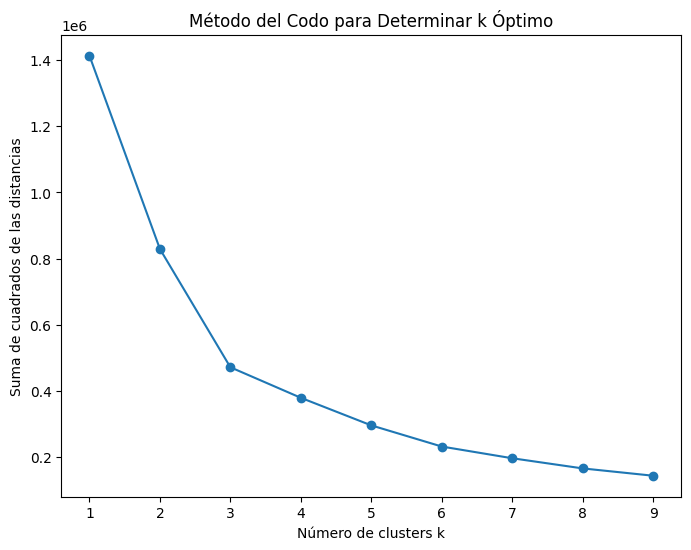

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Método del codo para encontrar el valor óptimo de k
sse = []
list_k = range(1, 10)
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(features_scaled)
    sse.append(km.inertia_)

# Gráfico del método del codo
plt.figure(figsize=(8, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel('Número de clusters k')
plt.ylabel('Suma de cuadrados de las distancias')
plt.title('Método del Codo para Determinar k Óptimo')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


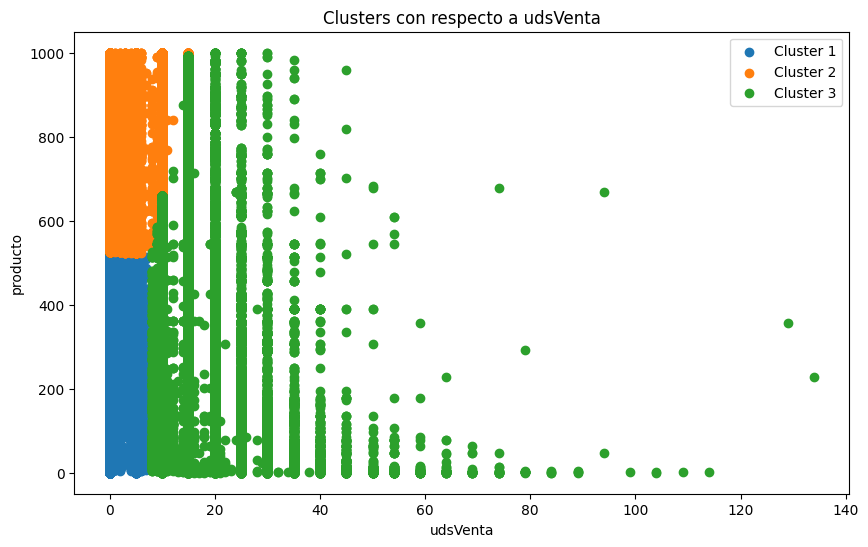

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Ajustar el modelo KMeans con el número óptimo de clusters
k_optimo = 3  # Debes cambiar esto con el valor óptimo determinado por el método del codo
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
kmeans.fit(features_scaled)  # Suponiendo que "features_scaled" es tu conjunto de datos escalados

# Obtener las etiquetas de cluster asignadas a cada punto
cluster_labels = kmeans.labels_

# Agregar las etiquetas de cluster al dataframe original
data_ventas_stock_calendario_out['cluster'] = cluster_labels

# Gráfico de los clusters con respecto a udsVenta
plt.figure(figsize=(10, 6))
for i in range(k_optimo):
    cluster_data = data_ventas_stock_calendario[data_ventas_stock_calendario_out['cluster'] == i]
    plt.scatter(cluster_data['udsVenta'], cluster_data['producto'], label=f'Cluster {i+1}')

plt.xlabel('udsVenta')
plt.ylabel('producto')
plt.title('Clusters con respecto a udsVenta')
plt.legend()
plt.show()


In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['cluster'] == 0]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media,cluster
0,1,2021-04-04,0,604,0,1,1,2021,4,4,6,0,13,24.516667,20.893184,87.196219,-38.162886,0.0,0
1,1,2021-04-05,0,604,0,1,1,2021,4,5,0,0,14,24.516667,20.893184,87.196219,-38.162886,0.0,0
7,1,2021-04-11,0,436,0,1,0,2021,4,11,6,1,14,24.516667,20.893184,87.196219,-38.162886,0.0,0
14,1,2021-04-18,0,460,0,1,0,2021,4,18,6,2,15,24.516667,20.893184,87.196219,-38.162886,0.0,0
21,1,2021-04-25,0,312,0,1,0,2021,4,25,6,3,16,24.516667,20.893184,87.196219,-38.162886,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373023,526,2023-03-28,0,208,1,0,0,2023,3,28,1,4,13,2.741935,4.116880,15.092577,-9.608706,0.0,0
373024,526,2023-03-29,0,208,1,0,0,2023,3,29,2,4,13,2.741935,4.116880,15.092577,-9.608706,0.0,0
373026,526,2023-03-31,0,158,1,0,0,2023,3,31,4,4,13,2.741935,4.116880,15.092577,-9.608706,0.0,0
373027,526,2023-04-01,0,158,1,0,0,2023,4,1,5,0,13,2.083333,4.247798,14.826726,-10.660060,0.0,0


In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['cluster'] == 1]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media,cluster
370115,523,2021-04-09,5,59,1,0,0,2021,4,9,4,1,14,4.333333,5.999058,22.330508,-13.663842,5.0,1
370116,523,2021-04-10,5,54,1,0,0,2021,4,10,5,1,14,4.333333,5.999058,22.330508,-13.663842,5.0,1
370125,523,2021-04-19,5,69,1,0,0,2021,4,19,0,2,16,4.333333,5.999058,22.330508,-13.663842,5.0,1
370126,523,2021-04-20,5,64,1,0,0,2021,4,20,1,2,16,4.333333,5.999058,22.330508,-13.663842,5.0,1
370127,523,2021-04-21,5,59,1,0,0,2021,4,21,2,3,16,4.333333,5.999058,22.330508,-13.663842,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706635,1000,2023-03-30,0,109,1,0,0,2023,3,30,3,4,13,2.983871,3.993815,14.965315,-8.997573,0.0,1
706636,1000,2023-03-31,0,109,1,0,0,2023,3,31,4,4,13,2.983871,3.993815,14.965315,-8.997573,0.0,1
706637,1000,2023-04-01,5,109,1,0,0,2023,4,1,5,0,13,2.916667,3.828048,14.400812,-8.567479,5.0,1
706638,1000,2023-04-02,0,109,0,1,0,2023,4,2,6,0,13,2.916667,3.828048,14.400812,-8.567479,0.0,1


In [ ]:
data_ventas_stock_calendario_out[data_ventas_stock_calendario_out['cluster'] == 2]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año,media_ventas,desviacion_estandar_ventas,umbral_superior,umbral_inferior,udsVenta_media,cluster
2,1,2021-04-06,45,604,1,0,1,2021,4,6,1,0,14,24.516667,20.893184,87.196219,-38.162886,45.0,2
3,1,2021-04-07,59,554,1,0,1,2021,4,7,2,1,14,24.516667,20.893184,87.196219,-38.162886,59.0,2
4,1,2021-04-08,10,495,1,0,0,2021,4,8,3,1,14,24.516667,20.893184,87.196219,-38.162886,10.0,2
5,1,2021-04-09,45,490,1,0,0,2021,4,9,4,1,14,24.516667,20.893184,87.196219,-38.162886,45.0,2
6,1,2021-04-10,10,446,1,0,0,2021,4,10,5,1,14,24.516667,20.893184,87.196219,-38.162886,10.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705788,999,2022-12-03,20,124,1,0,0,2022,12,3,5,0,48,5.241935,6.740349,25.462984,-14.979113,20.0,2
705815,999,2022-12-30,20,109,1,0,0,2022,12,30,4,4,52,5.241935,6.740349,25.462984,-14.979113,20.0,2
705819,999,2023-01-03,25,84,1,0,0,2023,1,3,1,0,1,5.564516,7.192029,27.140602,-16.011570,25.0,2
705892,999,2023-03-17,20,173,1,0,0,2023,3,17,4,2,11,4.354839,5.393064,20.534031,-11.824354,20.0,2


Entrenamiento

In [ ]:
columnas_deseadas = ['producto', 'idSecuencia', 'udsVenta', 'bolOpen', 'bolHoliday', 'estaEnPromocion', 'año', 'mes', 'dia', 'dia_semana', 'semana_mes', 'semana_año', 'cluster']
data_ventas_stock_calendario_out_red = data_ventas_stock_calendario_out[columnas_deseadas]

In [ ]:
# Para el cluster 0
train_c0 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] <= '2022-12-31') & (data_ventas_stock_calendario_out_red['cluster'] == 0)]
validation_c0 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-01-01') & (data_ventas_stock_calendario_out_red['idSecuencia'] <= '2023-02-28') & (data_ventas_stock_calendario_out_red['cluster'] == 0)]
test_c0 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-03-01') & (data_ventas_stock_calendario_out_red['cluster'] == 0)]

# Para el cluster 1
train_c1 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] <= '2022-12-31') & (data_ventas_stock_calendario_out_red['cluster'] == 1)]
validation_c1 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-01-01') & (data_ventas_stock_calendario_out_red['idSecuencia'] <= '2023-02-28') & (data_ventas_stock_calendario_out_red['cluster'] == 1)]
test_c1 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-03-01') & (data_ventas_stock_calendario_out_red['cluster'] == 1)]

# Para el cluster 2
train_c2 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] <= '2022-12-31') & (data_ventas_stock_calendario_out_red['cluster'] == 2)]
validation_c2 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-01-01') & (data_ventas_stock_calendario_out_red['idSecuencia'] <= '2023-02-28') & (data_ventas_stock_calendario_out_red['cluster'] == 2)]
test_c2 = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= '2023-03-01') & (data_ventas_stock_calendario_out_red['cluster'] == 2)]

# Verificar los tamaños de los conjuntos
print("Tamaño del conjunto de prueba (Cluster 0):", len(test_c0))
print("Tamaño del conjunto de prueba (Cluster 1):", len(test_c1))
print("Tamaño del conjunto de prueba (Cluster 2):", len(test_c2))


Tamaño del conjunto de prueba (Cluster 0): 13616
Tamaño del conjunto de prueba (Cluster 1): 14937
Tamaño del conjunto de prueba (Cluster 2): 4359


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Lista de los conjuntos de entrenamiento, validación y prueba para cada cluster
clusters = ['c0', 'c1', 'c2']

for cluster in clusters:
    # Seleccionar los conjuntos correspondientes para el cluster actual
    X_train = globals()[f"train_{cluster}"].drop(['udsVenta', 'idSecuencia'], axis=1)
    y_train = globals()[f"train_{cluster}"]['udsVenta']

    X_test = globals()[f"test_{cluster}"].drop(['udsVenta', 'idSecuencia'], axis=1)
    y_test = globals()[f"test_{cluster}"]['udsVenta']

    # Definir el rango de hiperparámetros a probar
    param_grid = {
        'n_estimators': [250, 500],
        'max_depth': [2, 4, 6]
    }

    # Inicializar el modelo RandomForestRegressor
    rf = RandomForestRegressor(random_state=42)

    # Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    # Ajustar GridSearchCV a los datos de entrenamiento
    grid_search.fit(X_train, y_train)

    # Obtener los mejores hiperparámetros encontrados
    best_params = grid_search.best_params_
    print(f"Mejores hiperparámetros (Cluster {cluster}):", best_params)

    # Obtener el mejor modelo
    best_rf_model = grid_search.best_estimator_

    # Hacer predicciones en el conjunto de prueba usando el mejor modelo
    predicciones = best_rf_model.predict(X_test)

    # Calcular el error cuadrático medio en el conjunto de prueba
    mse = mean_squared_error(y_test, predicciones)
    print(f"Error cuadrático medio en el conjunto de prueba (Cluster {cluster}):", mse)


Mejores hiperparámetros (Cluster c0): {'max_depth': 4, 'n_estimators': 250}
Error cuadrático medio en el conjunto de prueba (Cluster c0): 4.668485520580282
Mejores hiperparámetros (Cluster c1): {'max_depth': 6, 'n_estimators': 250}
Error cuadrático medio en el conjunto de prueba (Cluster c1): 7.111048848773684
Mejores hiperparámetros (Cluster c2): {'max_depth': 4, 'n_estimators': 250}
Error cuadrático medio en el conjunto de prueba (Cluster c2): 30.906698934892706


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Lista de los conjuntos de entrenamiento, validación y prueba para cada cluster
clusters = ['c0', 'c1', 'c2']

for cluster in clusters:
    # Seleccionar los conjuntos correspondientes para el cluster actual
    X_train = globals()[f"train_{cluster}"].drop(['udsVenta', 'idSecuencia'], axis=1)
    y_train = globals()[f"train_{cluster}"]['udsVenta']

    X_test = globals()[f"test_{cluster}"].drop(['udsVenta', 'idSecuencia'], axis=1)
    y_test = globals()[f"test_{cluster}"]['udsVenta']

    # Definir el rango de hiperparámetros a probar
    param_grid = {
        'n_estimators': [250, 500, 1000, 2000],
        'max_depth': [2, 4, 6, 10]
    }

    # Inicializar el modelo XGBRegressor
    xgb = XGBRegressor(random_state=42)

    # Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    # Ajustar GridSearchCV a los datos de entrenamiento
    grid_search.fit(X_train, y_train)

    # Obtener los mejores hiperparámetros encontrados
    best_params = grid_search.best_params_
    print(f"Mejores hiperparámetros (Cluster {cluster}):", best_params)

    # Obtener el mejor modelo
    best_xgb_model = grid_search.best_estimator_

    # Hacer predicciones en el conjunto de prueba usando el mejor modelo
    predicciones = best_xgb_model.predict(X_test)

    # Calcular el error cuadrático medio en el conjunto de prueba
    mse = mean_squared_error(y_test, predicciones)
    print(f"Error cuadrático medio en el conjunto de prueba (Cluster {cluster}):", mse)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros (Cluster c0): {'max_depth': 2, 'n_estimators': 250}
Error cuadrático medio en el conjunto de prueba (Cluster c0): 4.594074549716922


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros (Cluster c1): {'max_depth': 2, 'n_estimators': 250}
Error cuadrático medio en el conjunto de prueba (Cluster c1): 7.0113403204882605
Mejores hiperparámetros (Cluster c2): {'max_depth': 2, 'n_estimators': 250}
Error cuadrático medio en el conjunto de prueba (Cluster c2): 30.340060447955064


Probar con LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, explained_variance_score
import numpy as np

# Lista de los conjuntos de entrenamiento, validación y prueba para cada cluster
clusters = ['c0', 'c1', 'c2']

for cluster in clusters:
    # Seleccionar los conjuntos correspondientes para el cluster actual
    X_train = globals()[f"train_{cluster}"].drop(['udsVenta', 'idSecuencia'], axis=1)
    y_train = globals()[f"train_{cluster}"]['udsVenta']

    X_test = globals()[f"test_{cluster}"].drop(['udsVenta', 'idSecuencia'], axis=1)
    y_test = globals()[f"test_{cluster}"]['udsVenta']

    # Remodelar los datos de entrenamiento y prueba
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # Crear el modelo LSTM
    model = Sequential()
    model.add(LSTM(units=250, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='mse')

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    # Hacer predicciones en el conjunto de prueba
    predicciones = model.predict(X_test)

    # Calcular el error cuadrático medio en el conjunto de prueba
    mse = mean_squared_error(y_test, predicciones)
    print(f"Error cuadrático medio en el conjunto de prueba (Cluster {cluster}):", mse)

    # Calcular el RMSE
    rmse = np.sqrt(mse)
    print(f"RMSE en el conjunto de prueba (Cluster {cluster}):", rmse)

    # Calcular el Explained Variance Score
    evs = explained_variance_score(y_test, predicciones)
    print(f"Explained Variance Score (Cluster {cluster}):", evs)


Epoch 1/20
7747/7747 [==============================] - 59s 7ms/step - loss: 5.8793
Epoch 2/20
7747/7747 [==============================] - 55s 7ms/step - loss: 5.0190
Epoch 3/20
7747/7747 [==============================] - 55s 7ms/step - loss: 4.9386
Epoch 4/20
7747/7747 [==============================] - 53s 7ms/step - loss: 4.8876
Epoch 5/20
7747/7747 [==============================] - 55s 7ms/step - loss: 4.8596
Epoch 6/20
7747/7747 [==============================] - 54s 7ms/step - loss: 4.8541
Epoch 7/20
7747/7747 [==============================] - 56s 7ms/step - loss: 4.8504
Epoch 8/20
7747/7747 [==============================] - 53s 7ms/step - loss: 4.8462
Epoch 9/20
7747/7747 [==============================] - 54s 7ms/step - loss: 4.8464
Epoch 10/20
7747/7747 [==============================] - 53s 7ms/step - loss: 4.8410
Epoch 11/20
7747/7747 [==============================] - 58s 8ms/step - loss: 4.8407
Epoch 12/20
7747/7747 [==============================] - 55s 7ms/step - lo

# **RMSE por producto y día**

In [ ]:
columnas_deseadas = ['producto', 'idSecuencia', 'udsVenta', 'bolOpen', 'bolHoliday', 'estaEnPromocion', 'dia_semana', 'semana_mes', 'semana_año', 'cluster']
data_ventas_stock_calendario_out_red = data_ventas_stock_calendario_out[columnas_deseadas]

In [ ]:
data_ventas_stock_calendario_out_red.describe()

,producto,idSecuencia,udsVenta,bolOpen,bolHoliday,estaEnPromocion,dia_semana,semana_mes,semana_año,cluster
count,706640.000000,706640,706640.000000,706640.000000,706640.000000,706640.000000,706640.000000,706640.000000,706640.000000,706640.000000
mean,499.500000,2022-04-03 12:00:00,3.480757,0.843836,0.176712,0.242317,3.000000,1.830137,26.464384,1.542634
min,1.000000,2021-04-04 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,247.750000,2021-10-03 00:00:00,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,13.000000,0.000000
50%,499.500000,2022-04-03 12:00:00,0.000000,1.000000,0.000000,0.000000,3.000000,2.000000,26.000000,1.000000
75%,750.250000,2022-10-03 00:00:00,5.000000,1.000000,0.000000,0.000000,5.000000,3.000000,39.000000,3.000000
max,1000.000000,2023-04-03 00:00:00,134.000000,1.000000,1.000000,1.000000,6.000000,4.000000,52.000000,3.000000
std,289.284031,NaN,5.591276,0.363011,0.381425,0.428485,2.003423,1.292199,15.003187,1.191566


In [ ]:
data_ventas_stock_calendario_out_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706640 entries, 0 to 706639
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   producto         706640 non-null  int64         
 1   idSecuencia      706640 non-null  datetime64[ns]
 2   udsVenta         706640 non-null  int64         
 3   bolOpen          706640 non-null  int64         
 4   bolHoliday       706640 non-null  int64         
 5   estaEnPromocion  706640 non-null  int64         
 6   dia_semana       706640 non-null  int64         
 7   semana_mes       706640 non-null  int64         
 8   semana_año       706640 non-null  int64         
 9   cluster          706640 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(8)
memory usage: 51.2 MB


In [ ]:
# Define las fechas de inicio y fin para el conjunto de prueba
fecha_inicio_prueba = '2022-09-01'
fecha_fin_prueba = '2022-12-01'

# Filtra los datos para obtener el conjunto de entrenamiento
datos_entrenamiento = data_ventas_stock_calendario_out_red[~((data_ventas_stock_calendario_out_red['idSecuencia'] >= fecha_inicio_prueba) & (data_ventas_stock_calendario_out_red['idSecuencia'] < fecha_fin_prueba))]
datos_prueba = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= fecha_inicio_prueba) & (data_ventas_stock_calendario_out_red['idSecuencia'] < fecha_fin_prueba)]

# Verifica el tamaño del conjunto de entrenamiento
print("Tamaño del conjunto de entrenamiento:", len(datos_entrenamiento))
print("Tamaño del conjunto de prueba:", len(datos_prueba))

Tamaño del conjunto de entrenamiento: 618552
Tamaño del conjunto de prueba: 88088


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score
import numpy as np


# Selecciona características y objetivo para cada conjunto
X_train = datos_entrenamiento.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = datos_entrenamiento['udsVenta']

X_test = datos_prueba.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = datos_prueba['udsVenta']

# Inicializa el modelo XGBoost
modelo_xgb = XGBRegressor(random_state=42)

# Entrena el modelo en el conjunto de entrenamiento
modelo_xgb.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
predicciones = modelo_xgb.predict(X_test)

# Calcula el EVS
evs = explained_variance_score(y_test, predicciones)
print("Explained Variance Score:", evs)

# Calcula el RMSE
rmse = np.sqrt(mean_squared_error(y_test, predicciones))
print("Root Mean Squared Error:", rmse)


Explained Variance Score: 0.6688900937748579
Root Mean Squared Error: 3.172851191420422


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Entrena tu modelo XGBoost (usa el conjunto de entrenamiento completo)
modelo_xgb = XGBRegressor(random_state=42)
modelo_xgb.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
predicciones = modelo_xgb.predict(X_test)

# Agrega las predicciones al DataFrame de datos de prueba
datos_prueba['Prediccion'] = predicciones

# Calcula el RMSE por producto y día
rmse_por_producto_dia = datos_prueba.groupby(['producto', 'idSecuencia']).apply(lambda group: np.sqrt(mean_squared_error(group['udsVenta'], group['Prediccion'])))
print(rmse_por_producto_dia)


<ipython-input-49-8257588507a2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_prueba['Prediccion'] = predicciones


producto  idSecuencia
1         2022-09-01      3.289703
          2022-09-02     12.379875
          2022-09-03     12.200605
          2022-09-04      0.078903
          2022-09-05      3.786414
                           ...    
1000      2022-11-26      3.112044
          2022-11-27      0.197265
          2022-11-28      2.322648
          2022-11-29      2.102524
          2022-11-30      3.397241
Length: 88088, dtype: float64


In [ ]:
rmse_por_producto_dia

producto  idSecuencia
1         2022-09-01      3.289703
          2022-09-02     12.379875
          2022-09-03     12.200605
          2022-09-04      0.078903
          2022-09-05      3.786414
                           ...    
1000      2022-11-26      3.112044
          2022-11-27      0.197265
          2022-11-28      2.322648
          2022-11-29      2.102524
          2022-11-30      3.397241
Length: 88088, dtype: float64

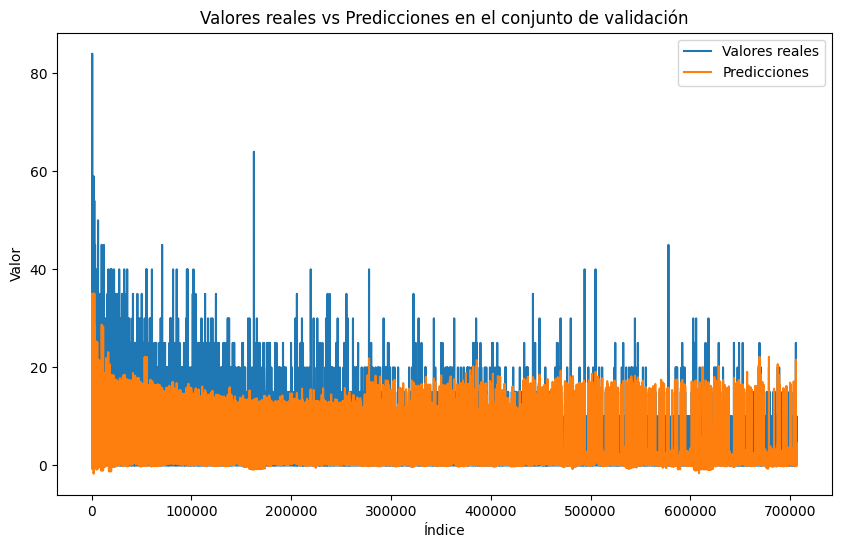

In [ ]:
import matplotlib.pyplot as plt

# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_test.index, y_test, label='Valores reales')
plt.plot(y_test.index, predicciones, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de test')
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, explained_variance_score
import numpy as np

# Crear y entrenar el modelo Naive Bayes Gaussiano
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
predictions_g = nb_model.predict(X_test)

# Calcular el error cuadrático medio (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions_g))
print("RMSE:", rmse)

# Calcular el Explained Variance Score (EVS)
evs = explained_variance_score(y_test, predictions_g)
print("EVS:", evs)

# Agrega las predicciones al DataFrame de datos de prueba
datos_prueba['Prediccion'] = predictions_g

# Calcula el RMSE por producto y día
rmse_por_producto_dia_g = datos_prueba.groupby(['producto', 'idSecuencia']).apply(lambda group: np.sqrt(mean_squared_error(group['udsVenta'], group['Prediccion'])))
print(rmse_por_producto_dia_g)


RMSE: 8.013267622920683
EVS: -0.7371784729232496


<ipython-input-55-aa855425c64b>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_prueba['Prediccion'] = predictions_g


producto  idSecuencia
1         2022-09-01     39.0
          2022-09-02     49.0
          2022-09-03     54.0
          2022-09-04      0.0
          2022-09-05      5.0
                         ... 
1000      2022-11-26      5.0
          2022-11-27      0.0
          2022-11-28      5.0
          2022-11-29      5.0
          2022-11-30      0.0
Length: 88088, dtype: float64


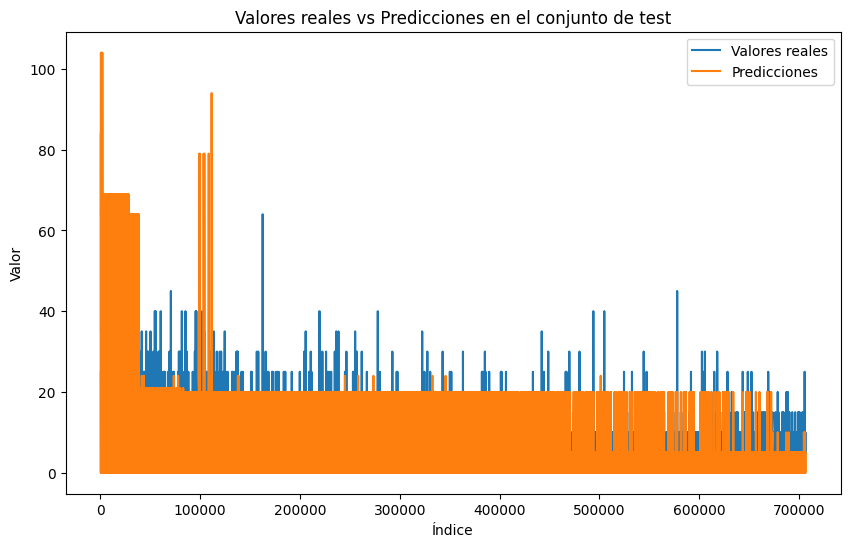

In [ ]:
import matplotlib.pyplot as plt

# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar los valores reales y las predicciones
plt.plot(y_test.index, y_test, label='Valores reales')
plt.plot(y_test.index, predictions_g, label='Predicciones')

# Agregar etiquetas y título
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Predicciones en el conjunto de test')
plt.legend()

# Mostrar el gráfico
plt.show()


# **Modelo por producto**

In [ ]:
columnas_deseadas = ['producto', 'idSecuencia', 'udsVenta', 'bolOpen', 'bolHoliday', 'estaEnPromocion', 'dia_semana', 'semana_mes', 'semana_año', 'cluster']
data_ventas_stock_calendario_out_red = data_ventas_stock_calendario_out[columnas_deseadas]

In [ ]:
data_ventas_stock_calendario_out_red.describe()

,producto,idSecuencia,udsVenta,bolOpen,bolHoliday,estaEnPromocion,dia_semana,semana_mes,semana_año,cluster
count,706640.000000,706640,706640.000000,706640.000000,706640.000000,706640.000000,706640.000000,706640.000000,706640.000000,706640.000000
mean,499.500000,2022-04-03 12:00:00,3.480757,0.843836,0.176712,0.242317,3.000000,1.830137,26.464384,1.542634
min,1.000000,2021-04-04 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,247.750000,2021-10-03 00:00:00,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,13.000000,0.000000
50%,499.500000,2022-04-03 12:00:00,0.000000,1.000000,0.000000,0.000000,3.000000,2.000000,26.000000,1.000000
75%,750.250000,2022-10-03 00:00:00,5.000000,1.000000,0.000000,0.000000,5.000000,3.000000,39.000000,3.000000
max,1000.000000,2023-04-03 00:00:00,134.000000,1.000000,1.000000,1.000000,6.000000,4.000000,52.000000,3.000000
std,289.284031,NaN,5.591276,0.363011,0.381425,0.428485,2.003423,1.292199,15.003187,1.191566


In [ ]:
# Define las fechas de inicio y fin para el conjunto de prueba
fecha_inicio_prueba = '2022-09-01'
fecha_fin_prueba = '2022-12-01'

# Filtra los datos para obtener el conjunto de entrenamiento
train = data_ventas_stock_calendario_out_red[~((data_ventas_stock_calendario_out_red['idSecuencia'] >= fecha_inicio_prueba) & (data_ventas_stock_calendario_out_red['idSecuencia'] < fecha_fin_prueba))]
test = data_ventas_stock_calendario_out_red[(data_ventas_stock_calendario_out_red['idSecuencia'] >= fecha_inicio_prueba) & (data_ventas_stock_calendario_out_red['idSecuencia'] < fecha_fin_prueba)]

# Verifica el tamaño del conjunto de entrenamiento
print("Tamaño del conjunto de entrenamiento:", len(train))
print("Tamaño del conjunto de prueba:", len(test))

Tamaño del conjunto de entrenamiento: 618552
Tamaño del conjunto de prueba: 88088


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']


X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Definir el rango de hiperparámetros a probar
param_grid = {
    'n_estimators': [250, 500, 1000],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'gamma': [0, 0.1, 0.2]
}

# Inicializar el modelo XGBoost
modelo_xgb = XGBRegressor(random_state=42)

# Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
grid_search = GridSearchCV(estimator=modelo_xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de prueba
predicciones_prueba = best_model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_prueba)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


rmse_test = np.sqrt(mse_test)
print("RMSE test:", rmse_test)


from sklearn.metrics import explained_variance_score

# Calcular el Explained Variance Score
evs = explained_variance_score(y_test, predicciones_prueba)

print("Explained Variance Score:", evs)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}
Error cuadrático medio en el conjunto de prueba: 10.073613695910538
RMSE test: 3.173895665567874
Explained Variance Score: 0.6687628580728162


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Inicializar y entrenar el modelo Random Forest
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)


# Hacer predicciones en el conjunto de prueba
predicciones_rf = modelo_rf.predict(X_test)


# Calcular el error cuadrático medio en el conjunto de prueba
mse_test_rf = mean_squared_error(y_test, predicciones_rf)
print("Error cuadrático medio en el conjunto de prueba:", mse_test_rf)

# Calcular RMSE
rmse_test_rf = np.sqrt(mse_test_rf)
print("RMSE en el conjunto de prueba:", rmse_test_rf)

# Calcular el Explained Variance Score
from sklearn.metrics import explained_variance_score
evs_rf = explained_variance_score(y_test, predicciones_rf)
print("Explained Variance Score:", evs_rf)


Error cuadrático medio en el conjunto de prueba: 12.642626040337023
RMSE en el conjunto de prueba: 3.5556470635226187
Explained Variance Score: 0.5848364125886045


In [ ]:
# Crear un DataFrame con los resultados
resultados_rf = test[['idSecuencia', 'producto', 'udsVenta']].copy()
resultados_rf['udsVenta_predichas'] = predicciones_rf
rmse_por_producto_rf = resultados_rf.groupby('producto').apply(lambda x: np.sqrt(mean_squared_error(x['udsVenta'], x['udsVenta_predichas']))).reset_index()
rmse_por_producto_rf.columns = ['producto', 'RMSE']

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Asegúrate de que tus datos estén en un formato adecuado para LSTM
# (número de muestras, número de pasos de tiempo, número de características)
# Esto puede requerir remodelar tus datos si aún no están en este formato

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']



# Remodelar los datos de entrenamiento y prueba
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=20)




Epoch 1/20
19330/19330 [==============================] - 61s 3ms/step - loss: 16.5852
Epoch 2/20
19330/19330 [==============================] - 52s 3ms/step - loss: 12.9215
Epoch 3/20
19330/19330 [==============================] - 60s 3ms/step - loss: 12.3878
Epoch 4/20
19330/19330 [==============================] - 52s 3ms/step - loss: 12.7638
Epoch 5/20
19330/19330 [==============================] - 53s 3ms/step - loss: 12.4016
Epoch 6/20
19330/19330 [==============================] - 53s 3ms/step - loss: 12.2264
Epoch 7/20
19330/19330 [==============================] - 51s 3ms/step - loss: 12.3478
Epoch 8/20
19330/19330 [==============================] - 55s 3ms/step - loss: 12.1961
Epoch 9/20
19330/19330 [==============================] - 51s 3ms/step - loss: 12.7168
Epoch 10/20
19330/19330 [==============================] - 52s 3ms/step - loss: 12.3486
Epoch 11/20
19330/19330 [==============================] - 52s 3ms/step - loss: 12.5263
Epoch 12/20
19330/19330 [================

NameError: name 'y_validation' is not defined

In [ ]:
# Hacer predicciones en el conjunto de prueba
predicciones_lstm = model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test, predicciones_lstm)
print("Error cuadrático medio en el conjunto de prueba:", mse_test)


# Calcula el RMSE
rmse = np.sqrt(mean_squared_error(y_test, predicciones_lstm))
print("Root Mean Squared Error:", rmse)

# Calcula el EVS
evs = explained_variance_score(y_test, predicciones_lstm)
print("Explained Variance Score:", evs)

2753/2753 [==============================] - 4s 1ms/step
Error cuadrático medio en el conjunto de prueba: 10.628022396535226
Root Mean Squared Error: 3.260064784100958
Explained Variance Score: 0.6513023715653072


In [ ]:
# Crear un DataFrame con los resultados
resultados_lstm = test[['idSecuencia', 'producto', 'udsVenta']].copy()
resultados_lstm['udsVenta_predichas'] = predicciones_lstm
rmse_por_producto_lstm = resultados_lstm.groupby('producto').apply(lambda x: np.sqrt(mean_squared_error(x['udsVenta'], x['udsVenta_predichas']))).reset_index()
rmse_por_producto_lstm.columns = ['producto', 'RMSE']

In [ ]:
rmse_por_producto_lstm

,producto,RMSE
0,1,15.626142
1,2,10.427158
2,3,8.911958
3,4,8.997974
4,5,8.550251
...,...,...
963,996,2.859715
964,997,3.218548
965,998,3.221880
966,999,4.868559


Dec. tree con hiperparametros

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']
X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Definir el rango de hiperparámetros a probar para el Decision Tree
param_grid_dt = {
    'max_depth': [5, 10, 20, 50],
    'min_samples_split': [2, 10, 20, 25],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Inicializar el modelo Decision Tree
modelo_dt = DecisionTreeRegressor(random_state=42)

# Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
grid_search_dt = GridSearchCV(estimator=modelo_dt, param_grid=param_grid_dt, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search_dt.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params_dt = grid_search_dt.best_params_
print("Mejores hiperparámetros:", best_params_dt)

# Obtener el mejor modelo
best_model_dt = grid_search_dt.best_estimator_

# Hacer predicciones en el conjunto de prueba
predicciones_dt = best_model_dt.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test_dt = mean_squared_error(y_test, predicciones_dt)
print("Error cuadrático medio en el conjunto de prueba:", mse_test_dt)

# Calcular RMSE
rmse_test_dt = np.sqrt(mse_test_dt)
print("RMSE en el conjunto de prueba:", rmse_test_dt)

# Calcular el Explained Variance Score
evs_dt = explained_variance_score(y_test, predicciones_dt)
print("Explained Variance Score:", evs_dt)

# Crear un DataFrame con los resultados
resultados_dt = test[['idSecuencia', 'producto', 'udsVenta']].copy()
resultados_dt['udsVenta_predichas'] = predicciones_dt

# Calcular el RMSE agrupado por producto
rmse_por_producto_dt = resultados_dt.groupby('producto').apply(lambda x: np.sqrt(mean_squared_error(x['udsVenta'], x['udsVenta_predichas']))).reset_index()
rmse_por_producto_dt.columns = ['producto', 'RMSE']

print(rmse_por_producto_dt)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Error cuadrático medio en el conjunto de prueba: 10.51697700181239
RMSE en el conjunto de prueba: 3.2429888994278704
Explained Variance Score: 0.6540135901741891
     producto       RMSE
0           1  15.567115
1           2  12.673936
2           3   8.761410
3           4   9.346815
4           5   7.877600
..        ...        ...
963       996   2.803854
964       997   3.140610
965       998   3.185912
966       999   5.041741
967      1000   2.974548

[968 rows x 2 columns]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']
X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Definir el rango de hiperparámetros a probar para el Decision Tree
param_grid_dt = {
    'max_depth': [1, 2, 3, 4, 5, 10],
    'min_samples_split': [1, 2, 10, 20, 25],
    'min_samples_leaf': [0.5, 1, 2, 5, 10]
}

# Inicializar el modelo Decision Tree
modelo_dt = DecisionTreeRegressor(random_state=42)

# Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
grid_search_dt = GridSearchCV(estimator=modelo_dt, param_grid=param_grid_dt, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search_dt.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params_dt = grid_search_dt.best_params_
print("Mejores hiperparámetros:", best_params_dt)

# Obtener el mejor modelo
best_model_dt = grid_search_dt.best_estimator_

# Hacer predicciones en el conjunto de prueba
predicciones_dt = best_model_dt.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test_dt = mean_squared_error(y_test, predicciones_dt)
print("Error cuadrático medio en el conjunto de prueba:", mse_test_dt)

# Calcular RMSE
rmse_test_dt = np.sqrt(mse_test_dt)
print("RMSE en el conjunto de prueba:", rmse_test_dt)

# Calcular el Explained Variance Score
evs_dt = explained_variance_score(y_test, predicciones_dt)
print("Explained Variance Score:", evs_dt)

# Crear un DataFrame con los resultados
resultados_dt = test[['idSecuencia', 'producto', 'udsVenta']].copy()
resultados_dt['udsVenta_predichas'] = predicciones_dt

# Calcular el RMSE agrupado por producto
rmse_por_producto_dt = resultados_dt.groupby('producto').apply(lambda x: np.sqrt(mean_squared_error(x['udsVenta'], x['udsVenta_predichas']))).reset_index()
rmse_por_producto_dt.columns = ['producto', 'RMSE']

print(rmse_por_producto_dt)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn

Mejores hiperparámetros: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Error cuadrático medio en el conjunto de prueba: 11.262330632972532
RMSE en el conjunto de prueba: 3.3559396050841754
Explained Variance Score: 0.6292617088373416
     producto       RMSE
0           1  20.489183
1           2  13.773510
2           3  11.363093
3           4  11.629734
4           5  11.131521
..        ...        ...
963       996   2.794695
964       997   3.110256
965       998   3.190906
966       999   5.391133
967      1000   2.979628

[968 rows x 2 columns]


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, explained_variance_score

# Seleccionar características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Definir el rango de hiperparámetros a probar para LightGBM
param_grid_lgb = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500]
}

# Inicializar el modelo LightGBM
modelo_lgb = lgb.LGBMRegressor()

# Inicializar GridSearchCV con el modelo y el rango de hiperparámetros
grid_search_lgb = GridSearchCV(estimator=modelo_lgb, param_grid=param_grid_lgb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search_lgb.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params_lgb = grid_search_lgb.best_params_
print("Mejores hiperparámetros:", best_params_lgb)

# Obtener el mejor modelo
best_model_lgb = grid_search_lgb.best_estimator_

# Hacer predicciones en el conjunto de prueba
predicciones_lgb = best_model_lgb.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test_lgb = mean_squared_error(y_test, predicciones_lgb)
print("Error cuadrático medio en el conjunto de prueba:", mse_test_lgb)

# Calcular RMSE
rmse_test_lgb = np.sqrt(mse_test_lgb)
print("RMSE en el conjunto de prueba:", rmse_test_lgb)

# Calcular el Explained Variance Score
evs_lgb = explained_variance_score(y_test, predicciones_lgb)
print("Explained Variance Score:", evs_lgb)

# Crear un DataFrame con los resultados
resultados_lgb = test[['idSecuencia', 'producto', 'udsVenta']].copy()
resultados_lgb['udsVenta_predichas'] = predicciones_lgb

# Calcular el RMSE agrupado por producto
rmse_por_producto_lgb = resultados_lgb.groupby('producto').apply(lambda x: np.sqrt(mean_squared_error(x['udsVenta'], x['udsVenta_predichas']))).reset_index()
rmse_por_producto_lgb.columns = ['producto', 'RMSE']

print(rmse_por_producto_lgb)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 618552, number of used features: 8
[LightGBM] [Info] Start training from score 3.488200
Mejores hiperparámetros: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 50}
Error cuadrático medio en el conjunto de prueba: 10.089553739430997
RMSE en el conjunto de prueba: 3.1764057894782582
Explained Variance Score: 0.6683564883047381
     producto       RMSE
0           1  15.650290
1           2  10.054161
2           3   8.759174
3           4   9.332857
4           5   8.611522
..        ...        ...
963       996   2.734153
964       997   3.101564
965       998   3.186787
966       999   4.320138
967      1000   3.153135

[968 rows x 2 columns]


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score
import numpy as np


# Selecciona características y objetivo para cada conjunto
X_train = train.drop(['udsVenta', 'idSecuencia'], axis=1)
y_train = train['udsVenta']

X_test = test.drop(['udsVenta', 'idSecuencia'], axis=1)
y_test = test['udsVenta']

# Inicializa el modelo XGBoost
params = {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}

# Entrenar el modelo XGBoost
modelo_xgb = XGBRegressor(**params)

# Entrena el modelo en el conjunto de entrenamiento
modelo_xgb.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
predicciones = modelo_xgb.predict(X_test)

# Calcula el EVS
evs = explained_variance_score(y_test, predicciones)
print("Explained Variance Score:", evs)

# Calcula el RMSE
rmse = np.sqrt(mean_squared_error(y_test, predicciones))
print("Root Mean Squared Error:", rmse)


Explained Variance Score: 0.6687628580728162
Root Mean Squared Error: 3.173895665567874


In [ ]:
# Crear un DataFrame con los resultados
resultados_xgb = test[['idSecuencia', 'producto', 'udsVenta']].copy()
resultados_xgb['udsVenta_predichas'] = predicciones
rmse_por_producto_xgb = resultados_xgb.groupby('producto').apply(lambda x: np.sqrt(mean_squared_error(x['udsVenta'], x['udsVenta_predichas']))).reset_index()
rmse_por_producto_xgb.columns = ['producto', 'RMSE']



In [ ]:
rmse_por_producto_xgb
rmse_por_producto_lgb
rmse_por_producto_dt
rmse_por_producto_lstm
rmse_por_producto_rf

,producto,RMSE
0,1,15.032867
1,2,12.462724
2,3,13.413702
3,4,10.571411
4,5,10.346438
...,...,...
963,996,3.093214
964,997,3.583128
965,998,3.655666
966,999,4.815388


In [ ]:
# Añadir una columna para identificar el modelo
rmse_por_producto_xgb['modelo'] = 'XGB'
rmse_por_producto_lgb['modelo'] = 'LGB'
rmse_por_producto_dt['modelo'] = 'DT'
rmse_por_producto_lstm['modelo'] = 'LSTM'
rmse_por_producto_rf['modelo'] = 'RF'

# Combinar todos los DataFrames en uno solo
rmse_combined = pd.concat([rmse_por_producto_xgb, rmse_por_producto_lgb, rmse_por_producto_dt, rmse_por_producto_lstm, rmse_por_producto_rf])

# Identificar el modelo con el menor RMSE para cada producto
idx_min_rmse = rmse_combined.groupby('producto')['RMSE'].idxmin()
best_rmse_by_product = rmse_combined.loc[idx_min_rmse]

# Ordenar por producto para una mejor visualización
best_rmse_by_product = best_rmse_by_product.sort_values(by='producto').reset_index(drop=True)

print(best_rmse_by_product)


      producto       RMSE modelo
0            1  15.651825    XGB
1            1  15.650290    LGB
2            1  20.489183     DT
3            1  15.626142   LSTM
4            1  15.032867     RF
...        ...        ...    ...
4835      1000   3.035368   LSTM
4836      1000   3.001237    XGB
4837      1000   3.153135    LGB
4838      1000   2.979628     DT
4839      1000   3.305948     RF

[4840 rows x 3 columns]


In [ ]:
# Guardar el resultado en un archivo CSV
best_rmse_by_product.to_csv('/content/drive/Othercomputers/Mi portátil/UOC/4o Semestre/TFM/Datos/best_rmse_by_product.csv', index=False)

In [ ]:
best_rmse_by_product

,producto,RMSE,modelo
0,1,15.651825,XGB
1,1,15.650290,LGB
2,1,20.489183,DT
3,1,15.626142,LSTM
4,1,15.032867,RF
...,...,...,...
4835,1000,3.035368,LSTM
4836,1000,3.001237,XGB
4837,1000,3.153135,LGB
4838,1000,2.979628,DT


# **Cálculo de Stock e Impacto económico**

In [ ]:
# Leer el archivo de Excel
file_path = "/content/drive/Othercomputers/Mi portátil/UOC/4o Semestre/TFM/Datos/DatosCicloAprovisionamiento.xlsx"
DatosCicloAprovisionamiento = pd.read_excel(file_path)

In [ ]:
DatosCicloAprovisionamiento['raiz_ciclo_aprovisionamiento'] = np.sqrt(DatosCicloAprovisionamiento['diasEntrePedidos'] + DatosCicloAprovisionamiento['diasLeadtime'])

In [ ]:
DatosCicloAprovisionamiento

,producto,diasEntrePedidos,diasLeadtime,raiz_ciclo_aprovisionamiento
0,1,14,15,5.385165
1,2,14,15,5.385165
2,3,14,15,5.385165
3,4,14,15,5.385165
4,5,14,15,5.385165
...,...,...,...,...
995,996,14,2,4.000000
996,997,14,2,4.000000
997,998,16,4,4.472136
998,999,7,2,3.000000


In [ ]:
# Paso 3: Calcular las unidades de stock (udsStock) diarias
factor_servicio = 1.64
DatosCicloAprovisionamiento = DatosCicloAprovisionamiento.merge(rmse_por_producto_xgb, on='producto')
DatosCicloAprovisionamiento['udsStock'] = factor_servicio * DatosCicloAprovisionamiento['RMSE'] * DatosCicloAprovisionamiento['raiz_ciclo_aprovisionamiento']


In [ ]:
DatosCicloAprovisionamiento

,producto,diasEntrePedidos,diasLeadtime,raiz_ciclo_aprovisionamiento,idSecuencia,udsVenta,udsVenta_predichas,RMSE_diario,udsStock,RMSE
0,1,14,15,5.385165,2022-09-01,25,28.135239,3.135239,138.231754,15.651825
1,1,14,15,5.385165,2022-09-02,15,28.091595,13.091595,138.231754,15.651825
2,1,14,15,5.385165,2022-09-03,15,29.117559,14.117559,138.231754,15.651825
3,1,14,15,5.385165,2022-09-04,0,0.080142,0.080142,138.231754,15.651825
4,1,14,15,5.385165,2022-09-05,0,2.768953,2.768953,138.231754,15.651825
...,...,...,...,...,...,...,...,...,...,...
88083,1000,14,2,4.000000,2022-11-26,5,2.007907,2.992093,19.688114,3.001237
88084,1000,14,2,4.000000,2022-11-27,0,0.091558,0.091558,19.688114,3.001237
88085,1000,14,2,4.000000,2022-11-28,0,2.234822,2.234822,19.688114,3.001237
88086,1000,14,2,4.000000,2022-11-29,0,2.139644,2.139644,19.688114,3.001237


In [ ]:
# Leer el archivo de Excel
file_path = "/content/drive/Othercomputers/Mi portátil/UOC/4o Semestre/TFM/Datos/DatosPrecioMedio.xlsx"
DatosPrecioMedio = pd.read_excel(file_path)

In [ ]:
DatosPrecioMedio

,producto,eurPrecioMedio
0,1,68.730000
1,2,148.330000
2,3,169.000000
3,4,0.604383
4,5,4.553314
...,...,...
995,996,17.120000
996,997,17.710000
997,998,8.270000
998,999,8.270000


In [ ]:
DatosPrecioMedio = DatosPrecioMedio.merge(DatosCicloAprovisionamiento, on='producto')

In [ ]:
factor = 0.05
DatosPrecioMedio['CosteStock'] = factor * DatosPrecioMedio['udsStock'] * DatosPrecioMedio['eurPrecioMedio']


In [ ]:
DatosPrecioMedio

,producto,eurPrecioMedio,diasEntrePedidos,diasLeadtime,raiz_ciclo_aprovisionamiento,idSecuencia,udsVenta,udsVenta_predichas,RMSE_diario,udsStock,RMSE,CosteStock
0,1,68.73,14,15,5.385165,2022-09-01,25,28.135239,3.135239,138.231754,15.651825,475.033423
1,1,68.73,14,15,5.385165,2022-09-02,15,28.091595,13.091595,138.231754,15.651825,475.033423
2,1,68.73,14,15,5.385165,2022-09-03,15,29.117559,14.117559,138.231754,15.651825,475.033423
3,1,68.73,14,15,5.385165,2022-09-04,0,0.080142,0.080142,138.231754,15.651825,475.033423
4,1,68.73,14,15,5.385165,2022-09-05,0,2.768953,2.768953,138.231754,15.651825,475.033423
...,...,...,...,...,...,...,...,...,...,...,...,...
88083,1000,40.73,14,2,4.000000,2022-11-26,5,2.007907,2.992093,19.688114,3.001237,40.094844
88084,1000,40.73,14,2,4.000000,2022-11-27,0,0.091558,0.091558,19.688114,3.001237,40.094844
88085,1000,40.73,14,2,4.000000,2022-11-28,0,2.234822,2.234822,19.688114,3.001237,40.094844
88086,1000,40.73,14,2,4.000000,2022-11-29,0,2.139644,2.139644,19.688114,3.001237,40.094844


In [ ]:
# Quedarse con la primera fila de cada producto
DatosPrecioMedio_unico = DatosPrecioMedio.drop_duplicates(subset='producto', keep='first')


In [ ]:
DatosPrecioMedio_unico['CosteStock_365'] = 365 * DatosPrecioMedio_unico['CosteStock']

<ipython-input-75-beb8c85c469d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DatosPrecioMedio_unico['CosteStock_365'] = 365 * DatosPrecioMedio_unico['CosteStock']


In [ ]:
DatosPrecioMedio_unico

,producto,eurPrecioMedio,diasEntrePedidos,diasLeadtime,raiz_ciclo_aprovisionamiento,idSecuencia,udsVenta,udsVenta_predichas,RMSE_diario,udsStock,RMSE,CosteStock,CosteStock_365
0,1,68.730000,14,15,5.385165,2022-09-01,25,28.135239,3.135239,138.231754,15.651825,475.033423,173387.199517
91,2,148.330000,14,15,5.385165,2022-09-01,25,28.135239,3.135239,89.702038,10.156860,665.275161,242825.433908
182,3,169.000000,14,15,5.385165,2022-09-01,15,28.135239,13.135239,78.399516,8.877088,662.475909,241803.706947
273,4,0.604383,14,15,5.385165,2022-09-01,20,28.135239,8.135239,83.536275,9.458718,2.524395,921.404173
364,5,4.553314,14,15,5.385165,2022-09-01,20,22.904249,2.904249,75.995012,8.604829,17.301459,6315.032395
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87633,996,17.120000,14,2,4.000000,2022-09-01,0,2.362567,2.362567,18.249976,2.782009,15.621980,5702.022631
87724,997,17.710000,14,2,4.000000,2022-09-01,0,2.362567,2.362567,20.688775,3.153777,18.319910,6686.767178
87815,998,8.270000,16,4,4.472136,2022-09-01,10,3.093204,6.906796,23.660727,3.226036,9.783710,3571.054307
87906,999,8.270000,7,2,3.000000,2022-09-01,10,2.362567,7.637433,23.632927,4.803441,9.772216,3566.858663


In [ ]:
sumatorio_CosteStock_365 = DatosPrecioMedio_unico['CosteStock_365'].sum()

In [ ]:
sumatorio_CosteStock_365

18959861.140968844

Ahora para Naives

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, explained_variance_score
import numpy as np

# Crear y entrenar el modelo Naive Bayes Gaussiano
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
predictions_g = nb_model.predict(X_test)

# Calcular el error cuadrático medio (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions_g))
print("RMSE:", rmse)

# Calcular el Explained Variance Score (EVS)
evs = explained_variance_score(y_test, predictions_g)
print("EVS:", evs)




RMSE: 8.013267622920683
EVS: -0.7371784729232496


In [ ]:
# Crear un DataFrame con los resultados
resultados_nb = test[['idSecuencia', 'producto', 'udsVenta']].copy()
resultados_nb['udsVenta_predichas'] = predictions_g
rmse_por_producto_nb = resultados_nb.groupby('producto').apply(lambda x: np.sqrt(mean_squared_error(x['udsVenta'], x['udsVenta_predichas']))).reset_index()
rmse_por_producto_nb.columns = ['producto', 'RMSE']



In [ ]:
# Leer el archivo de Excel
file_path = "/content/drive/Othercomputers/Mi portátil/UOC/4o Semestre/TFM/Datos/DatosCicloAprovisionamiento.xlsx"
DatosCicloAprovisionamiento = pd.read_excel(file_path)

In [ ]:
DatosCicloAprovisionamiento['raiz_ciclo_aprovisionamiento'] = np.sqrt(DatosCicloAprovisionamiento['diasEntrePedidos'] + DatosCicloAprovisionamiento['diasLeadtime'])

In [ ]:
# Paso 3: Calcular las unidades de stock (udsStock) diarias
factor_servicio = 1.64
DatosCicloAprovisionamiento = DatosCicloAprovisionamiento.merge(rmse_por_producto_nb, on='producto')
DatosCicloAprovisionamiento['udsStock'] = factor_servicio * DatosCicloAprovisionamiento['RMSE'] * DatosCicloAprovisionamiento['raiz_ciclo_aprovisionamiento']


In [ ]:
# Leer el archivo de Excel
file_path = "/content/drive/Othercomputers/Mi portátil/UOC/4o Semestre/TFM/Datos/DatosPrecioMedio.xlsx"
DatosPrecioMedio = pd.read_excel(file_path)

In [ ]:
DatosPrecioMedio = DatosPrecioMedio.merge(DatosCicloAprovisionamiento, on='producto')

In [ ]:
factor = 0.05
DatosPrecioMedio['CosteStock'] = factor * DatosPrecioMedio['udsStock'] * DatosPrecioMedio['eurPrecioMedio']


In [ ]:
# Quedarse con la primera fila de cada producto
DatosPrecioMedio_unico = DatosPrecioMedio.drop_duplicates(subset='producto', keep='first')


In [ ]:
DatosPrecioMedio_unico['CosteStock_365'] = 365 * DatosPrecioMedio_unico['CosteStock']

In [ ]:
DatosPrecioMedio_unico

,producto,eurPrecioMedio,diasEntrePedidos,diasLeadtime,raiz_ciclo_aprovisionamiento,RMSE,udsStock,CosteStock,CosteStock_365
0,1,68.730000,14,15,5.385165,41.960735,370.583378,1273.509778,4.648311e+05
1,2,148.330000,14,15,5.385165,44.713742,394.897022,2928.753766,1.068995e+06
2,3,169.000000,14,15,5.385165,39.490436,348.766507,2947.076982,1.075683e+06
3,4,0.604383,14,15,5.385165,35.234224,311.177050,9.403505,3.432279e+03
4,5,4.553314,14,15,5.385165,32.765903,289.377651,65.881370,2.404670e+04
...,...,...,...,...,...,...,...,...,...
963,996,17.120000,14,2,4.000000,4.260733,27.950409,23.925550,8.732826e+03
964,997,17.710000,14,2,4.000000,3.877237,25.434675,22.522405,8.220678e+03
965,998,8.270000,16,4,4.472136,4.160251,30.512545,12.616937,4.605182e+03
966,999,8.270000,7,2,3.000000,6.000000,29.520000,12.206520,4.455380e+03


In [ ]:
sumatorio_CosteStock_365 = DatosPrecioMedio_unico['CosteStock_365'].sum()

In [ ]:
sumatorio_CosteStock_365

34863138.280626394